# Deep Neural Network (DNN)

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Conditional Variational Autoencoder (cVAE) in the design of connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

Deep Neural Network implementation and application, based on a dataset of steel frame corners with given features (geometric and material parameters) and targets (Moment and Shear Resistance). The DNN is built, trained and evaluated. 

**Dependencies**: 
- `DNN.py`
- `Datareader.py`
- `Settings.py`
- `Plot_Functions.py`

**Generates**:
- `Saved Models\DNN_Model_Full_V2\DNN_Model_Full_V2.pth`

## Setup

### Import

In [1]:
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import binned_statistic_2d
from scipy.stats import norm
from scipy import stats

import torch
import torch.nn as nn
import torch.optim as optim

from Settings import Directory, Plotting_Parameters

import DataReader
importlib.reload(DataReader)
from DataReader import DataReader

import DNN
importlib.reload(DNN)
from DNN import DNN

import warnings
warnings.filterwarnings('ignore')

### Directory

In [ ]:
directory = Directory()
plot_params = Plotting_Parameters()

# Presentation Settigs
plot_params.params['figure.dpi']=300
plot_params.update()

model_name = "DNN_Model_Full_V3"

DATA_FILE = r"Data\Knee_Connection_Output_red.csv"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)

if not os.path.exists(MODEL_SAVE_PATH):
    os.mkdir(MODEL_SAVE_PATH)
else: 
    print('Models available to load:')
    for file in os.listdir("Saved Models"):
        print(file)

MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
Models available to load:
CVAE_Exp01
CVAE_Exp02
CVAE_Exp03
CVAE_Model
CVAE_Model_Test
CVAE_Simple
CVAE_Test_01
CVAE_Test_02
CVAE_Test_03
CVAE_Test_04
CVAE_Test_05
CVAE_Test_06
CVAE_Test_07
DNN_Model_AL_Finetuned
DNN_Model_AL_Finetuned_FilterOn
DNN_Model_AL_Finetuned_test
DNN_Model_BALD
DNN_Model_BALD_V2
DNN_Model_BALD_V3
DNN_Model_Full
DNN_Model_Full_AllFeatures
DNN_Model_Full_Extern
DNN_Model_Full_V2
DNN_Model_Full_V3
DNN_Model_Hypercubes_m5
DNN_Model_LAL_Retrain
DNN_Model_LHS


### Load Data

In [3]:
datareader = DataReader()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
df_full_filtered.csv
Extended_Database.csv
Extended_Database_filtered_converted.csv
Extended_Database_FilterOn.csv
Extended_Database_test.csv
extended_profiles_filteron_iter_1.csv
extended_profiles_iter_1.csv
extended_profiles_iter_2.csv
extended_profiles_iter_3.csv
GAL_Generated_Data.csv
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx
_OLD


In [4]:
df_full = datareader.load("Knee_Connection_Output_red.csv")

Knee_Connection_Output_red.csv: (714385, 53)


#### Initialize Model

In [5]:
model = DNN()

model.config['epochs'] = 1000
model.config['dropout_prob'] = 0.00
model.config['neurons_per_layer'] = [64, 32, 16]
model.config['seed'] = 42
model.config['learning_rate'] = 0.005

#### Data Reduction

Data reduction factor states by how many features dataset should be reduced. Reduces dimensionality, but also length of the dataset. Use `data_reduction_factor=5` for a balanced reduction, which is easy to compute and still representative of the data.

In [6]:
model.data['data_reduction_factor'] = 0

In [7]:
df, model = datareader.reduce(df_full, model)
print(df.shape)

(714385, 53)


## Load Model

In [ ]:
model = DNN()
model = torch.load(MODEL_SAVE_FILE)
df = df_full.loc[model.data['data_indeces']]

for key, value in model.config.items():
    print(key, value)

batch_size 256
epochs 2500
learning_rate 0.001
test_size 0.1
val_size 0.1
print_logs True
dropout_prob 0.0
num_layers 3
neurons_per_layer [128, 64, 32, 16, 8]
use_batch_norm True
seed 42
description Different to V2, do not Cat_h & Cath_stiffc features
0


If Model loaded skip **Create Model** section.

## Create Model (Skip if Model is loaded)

In [27]:
for line in model.config:
    print(line+":", model.config[line])

batch_size: 256
epochs: 1000
learning_rate: 0.005
test_size: 0.1
val_size: 0.1
print_logs: True
dropout_prob: 0.0
num_layers: 3
neurons_per_layer: [64, 32, 16]
use_batch_norm: False
seed: 42


### Prepare Data, Build Model, Train Model

In [28]:
model.prepare_data(df)
model.build()
model.train()

Number of training samples: 571508
Number of validation samples: 71438
Number of testing samples: 71439
Epoch 1/1000, Train Loss: 0.002563, Val Loss: 0.000982
Epoch 2/1000, Train Loss: 0.000832, Val Loss: 0.000628
Epoch 3/1000, Train Loss: 0.000619, Val Loss: 0.000616
Epoch 4/1000, Train Loss: 0.000504, Val Loss: 0.000552
Epoch 5/1000, Train Loss: 0.000432, Val Loss: 0.000403
Epoch 6/1000, Train Loss: 0.000385, Val Loss: 0.000482
Epoch 7/1000, Train Loss: 0.000348, Val Loss: 0.000327
Epoch 8/1000, Train Loss: 0.000323, Val Loss: 0.000230
Epoch 9/1000, Train Loss: 0.000307, Val Loss: 0.000339
Epoch 10/1000, Train Loss: 0.000286, Val Loss: 0.000438
Epoch 11/1000, Train Loss: 0.000275, Val Loss: 0.000271
Epoch 12/1000, Train Loss: 0.000266, Val Loss: 0.000261
Epoch 13/1000, Train Loss: 0.000256, Val Loss: 0.000233
Epoch 14/1000, Train Loss: 0.000252, Val Loss: 0.000220
Epoch 15/1000, Train Loss: 0.000246, Val Loss: 0.000223
Epoch 16/1000, Train Loss: 0.000241, Val Loss: 0.000274
Epoch 17/

### Save Model

In [ ]:
if not load_model:
    model.save(MODEL_SAVE_FILE)

Model saved to: Saved Models\DNN_Model_Full\DNN_Model_Full.pth


## Evaluate Test Data

### Coefficient of Variation $R^2$

In [20]:
y_pred, test_loss = model.evaluate()
y_true = model.y_test.numpy()
model_metrics = model.get_metrics(y_pred.numpy())
print(model_metrics)

{'MSE': 3.0903888e-05, 'RMSE': 0.0055591264, 'MAE': 0.0037376885, 'R2': 0.9979280408006161, 'MCDMS': 0.005261143387924681, 'MCDUS': 0.057724938294168596}


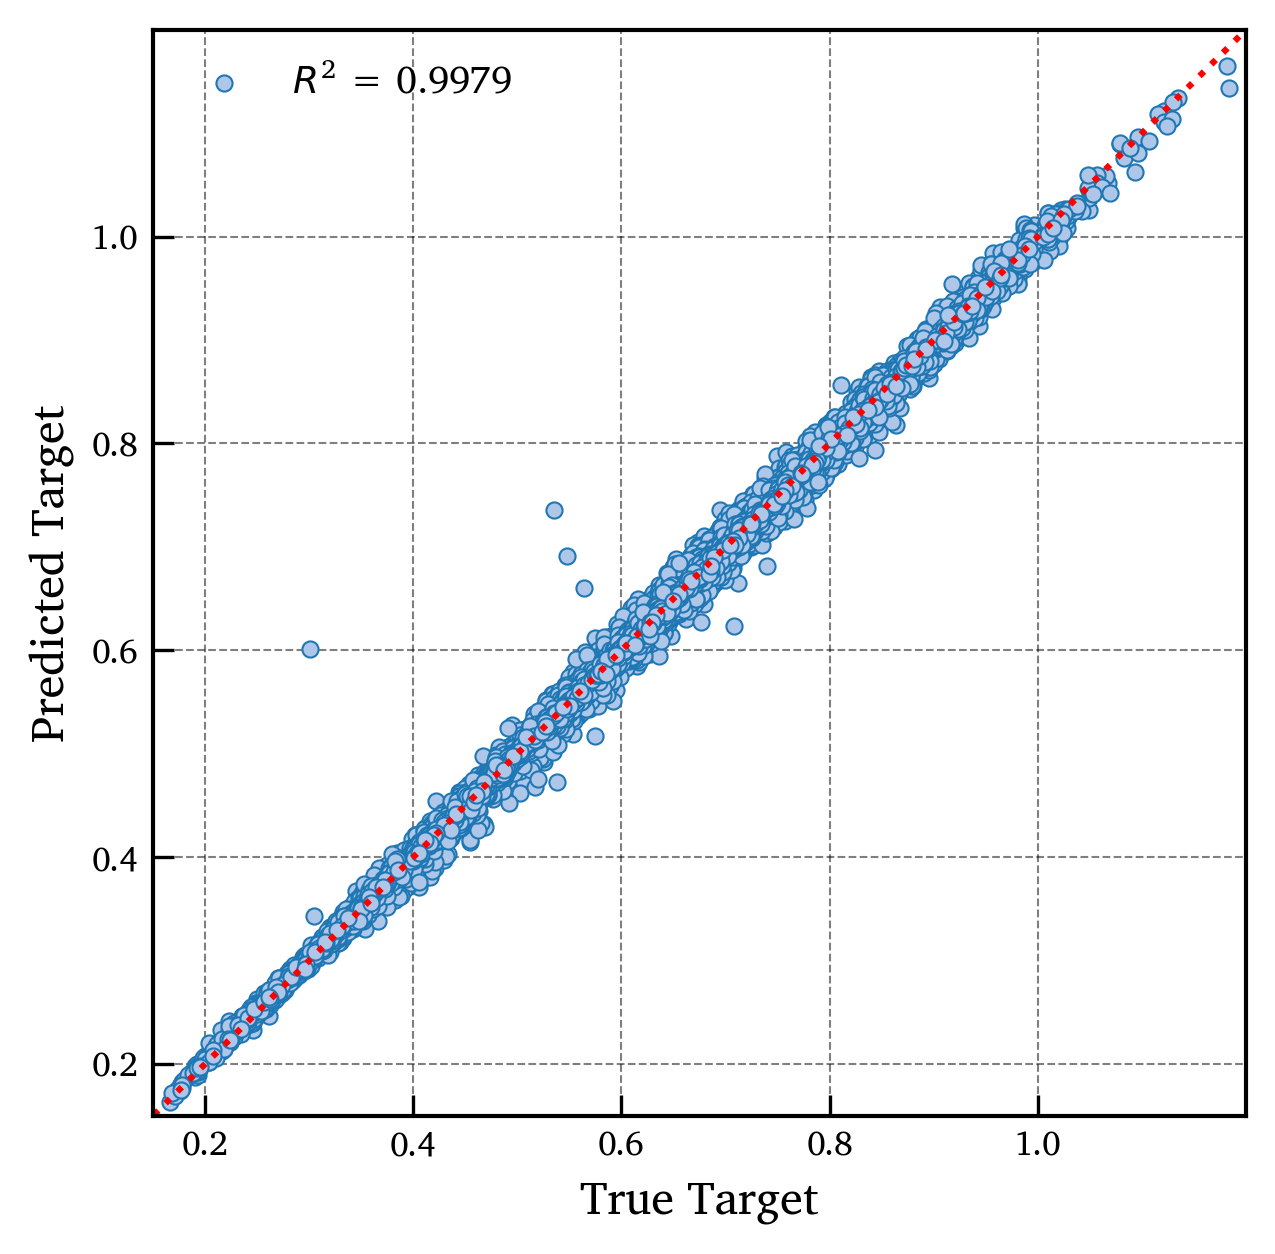

In [27]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.75,1.0))

plt.scatter(y_true, y_pred.numpy(), s=15, 
            facecolor=plot_params.morecolors[1], 
            edgecolors=plot_params.morecolors[0],
            linewidth=0.5,
            zorder=2,
            label=rf'$R^2$ = {model_metrics["R2"]:.4f}')
plt.plot([-1,2], [-1, 2], 
         color='red',
         linestyle='dotted',
         linewidth=1.5, 
         zorder=2)

plt.xlim([0.9*min(y_true), max(y_true)+0.1*min(y_true)])
plt.ylim([0.9*min(y_true), max(y_true)+0.1*min(y_true)])

plt.legend()
plt.grid(True, which='major', color='k', linestyle='--',linewidth=0.5, alpha=0.5, zorder=0)

plt.ylabel("Predicted Target")
plt.xlabel("True Target")
plt.show()

### Uncertainity with Monte Carlo Dropout

In [28]:
print('Dropout rate from training: {}'.format(model.config['dropout_prob']))

Dropout rate from training: 0.0


If Dropout rate is $=0$ for training, then set Dropout rate $>0$ for evalution. Else the Monte Carlo Dropout will only deliver singular values.

`model.mc_dropout_uncertainity` delivers $N_{\text{MCforwardpasses}}$ prediction on the test set, hence `preds_mc_dropout` will have the shape ($N_{\text{MCforwardpasses}},N_{\text{testset}}$). For each test set sample $N_{\text{MCforwardpasses}}$ have been made, from which the mean $\mu_{\text{MC}}$ and the variance $\sigma_{\text{MC}}^2$ can be calculated. From this the **coefficient of variation** can be calulcated as $\sigma_{\text{MC}} / \mu_{\text{MC}}$, which is the uncertainty of the test sample.

In [29]:
preds_mc_dropout_mean, preds_mc_dropout_std, preds_mc_dropout = model.mc_dropout_uncertainty(num_samples=1000,
                                                                                             dropout_prob=0.1)

Get uncertainty on test set:

In [30]:
mcd_var = preds_mc_dropout.var(axis=0)
mcd_mean = preds_mc_dropout.mean(axis=0)
mcd_std = preds_mc_dropout.std(axis=0)

uncertainty = np.abs(mcd_std) / mcd_mean

Get error on test set:

In [31]:
y_truth = model.y_test.numpy()
y_pred = y_pred.numpy()
error = y_pred - y_truth
relative_error = error / (y_truth+1e-4)
relative_deviation = (relative_error)*100

**Error depending on predicted target**

Visualy, the _uncertainty_ does not seem to correlate too much with the _error_. However, for our **AL**, this correlation would be beneficial. Hence, we will investigate the existence and extent of this correlation further.

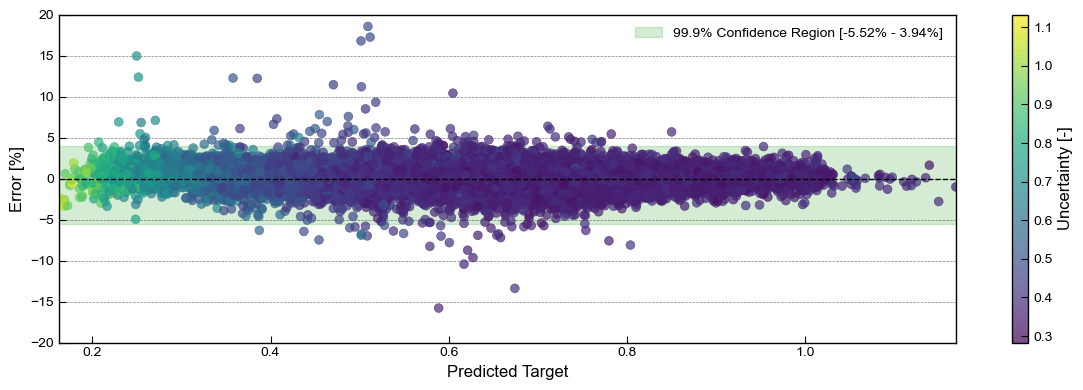

In [15]:
fig, ax = plt.subplots(figsize=(12,4))

confidence = 99.9

percentile_lower, percentile_upper = np.percentile(relative_deviation, [(100-confidence)/2, confidence-(100-confidence)/2])

plt.scatter(y_pred, relative_deviation,
            s=40, 
            c=uncertainty,
            linewidth=0.5,
            alpha=0.7,
            zorder=2)

plt.axhline(y=0, color='black', linestyle='--', linewidth=1.0, zorder=2)

plt.fill_between(
    x=[0, 1.2],  # Cover full x-range
    y1=percentile_lower,
    y2=percentile_upper,
    color=plot_params.morecolors[4],
    alpha=0.2,
    label=f"{confidence}% Confidence Region [{percentile_lower:.2f}% - {percentile_upper:.2f}%]",
    zorder=0
)

plt.colorbar(label='Uncertainty [-]')

plt.xlabel("Predicted Target")
plt.ylabel("Error [%]")

plt.xlim([min(y_pred),max(y_pred)])
plt.ylim([-20,20])

plt.yticks(np.arange(-20, 20+1, 5))
plt.grid(True, axis='y', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)

plt.legend()

plt.tight_layout()
plt.show()

### Uncertainty and Error Correlation

**Mean and deviation of uncertainty and error for each target bin**

By plotting the mean and deviation of the _uncertainty_ and _error_ for each target bin, a _positive_ correlation between the two can be noted. Lower predicted targets are more prone to errors, while also having a large uncertainty attached to it.

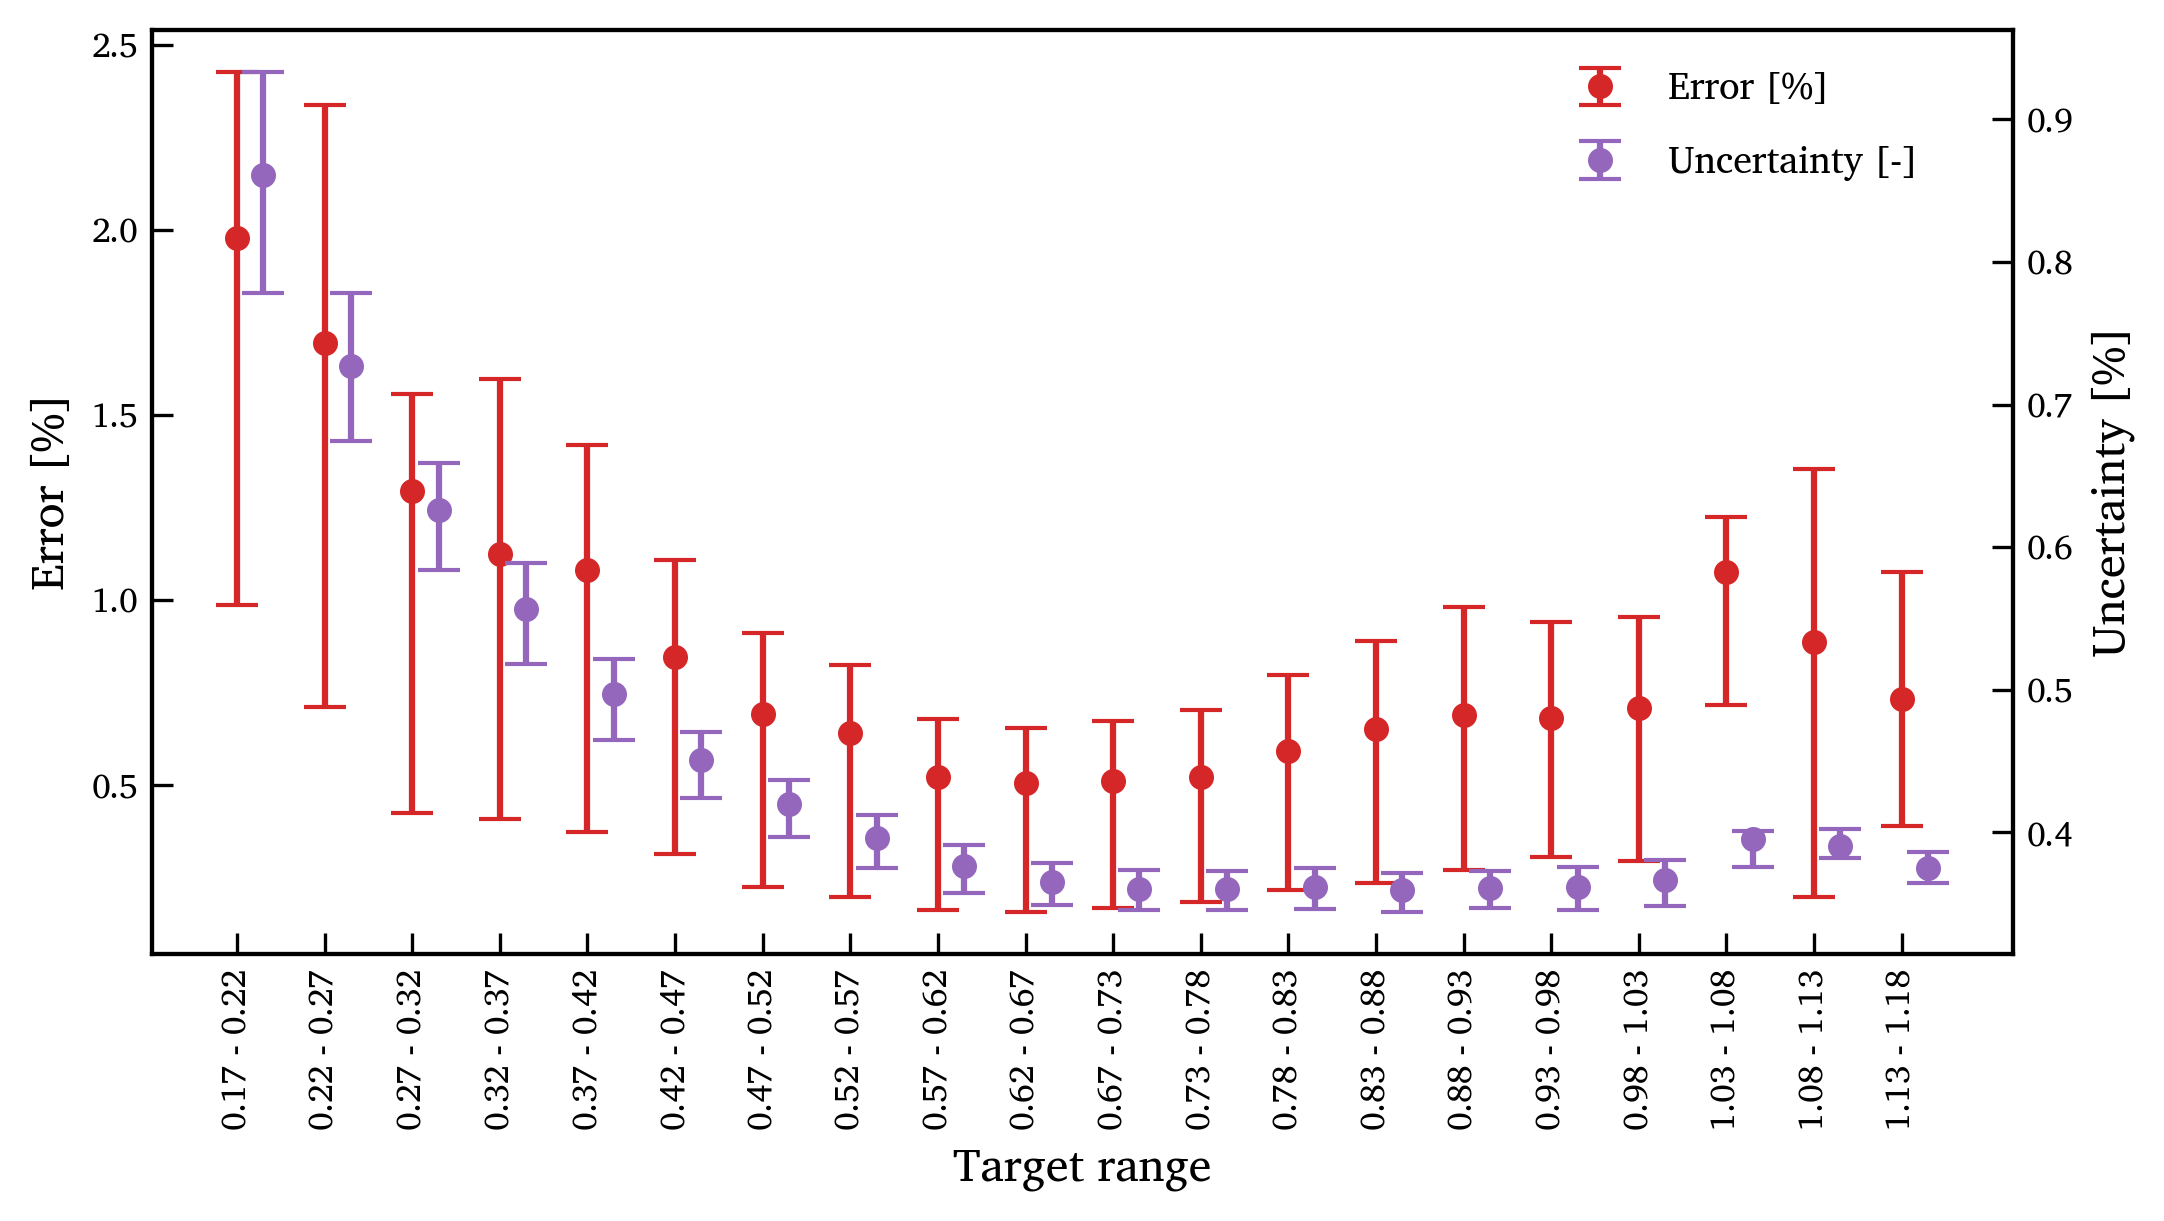

In [91]:
fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()

counts, bins = np.histogram(y_true, bins=20)

for i in range(len(counts)):
    mask = np.logical_and(y_true >= bins[i], y_true < bins[i+1])

    error_bin = np.abs(relative_deviation)[mask]
    uncertainty_bin = uncertainty[mask]

    error_bin_mean = error_bin.mean()
    uncertainty_bin_mean = uncertainty_bin.mean()

    confidence = 50
    uncertainty_lower_val = np.percentile(uncertainty_bin, (100 - confidence) / 2)
    uncertainty_upper_val = np.percentile(uncertainty_bin, confidence + (100 - confidence) / 2)
    error_lower_val = np.percentile(error_bin, (100 - confidence) / 2)
    error_upper_val = np.percentile(error_bin, confidence + (100 - confidence) / 2)

    uncertainty_lower_bound = uncertainty_bin_mean - uncertainty_lower_val
    uncertainty_upper_bound = uncertainty_upper_val - uncertainty_bin_mean
    error_lower_bound = error_bin_mean - error_lower_val
    error_upper_bound = error_upper_val - error_bin_mean

    uncertainty_bounds = np.array([[uncertainty_lower_bound], [uncertainty_upper_bound]])
    error_bounds = np.array([[error_lower_bound], [error_upper_bound]])

    if i==0:
        label1='Error [%]'
        label2='Uncertainty [-]'
    else:
        label1=None
        label2=None
    ax1.errorbar(i, error_bin_mean, yerr=error_bounds, fmt='o', color=plot_params.colors[3], markersize=5, capsize=5,
                 label=label1)
    ax2.errorbar(i+0.3, uncertainty_bin_mean, yerr=uncertainty_bounds, fmt='o', color=plot_params.colors[4], markersize=5, capsize=5,
                 label=label2)

ax1.set_xlabel('Target range')
ax1.set_ylabel('Error [%]')
ax2.set_ylabel('Uncertainty [%]')
ax1.set_xticks(np.arange(len(counts)))
ax1.set_xticklabels([f"{bins[i]:.2f} - {bins[i+1]:.2f}" for i in range(len(counts))],rotation=90)
ax1.legend(loc=[0.75, 0.9])
ax2.legend(loc=[0.75, 0.82])

plt.show()

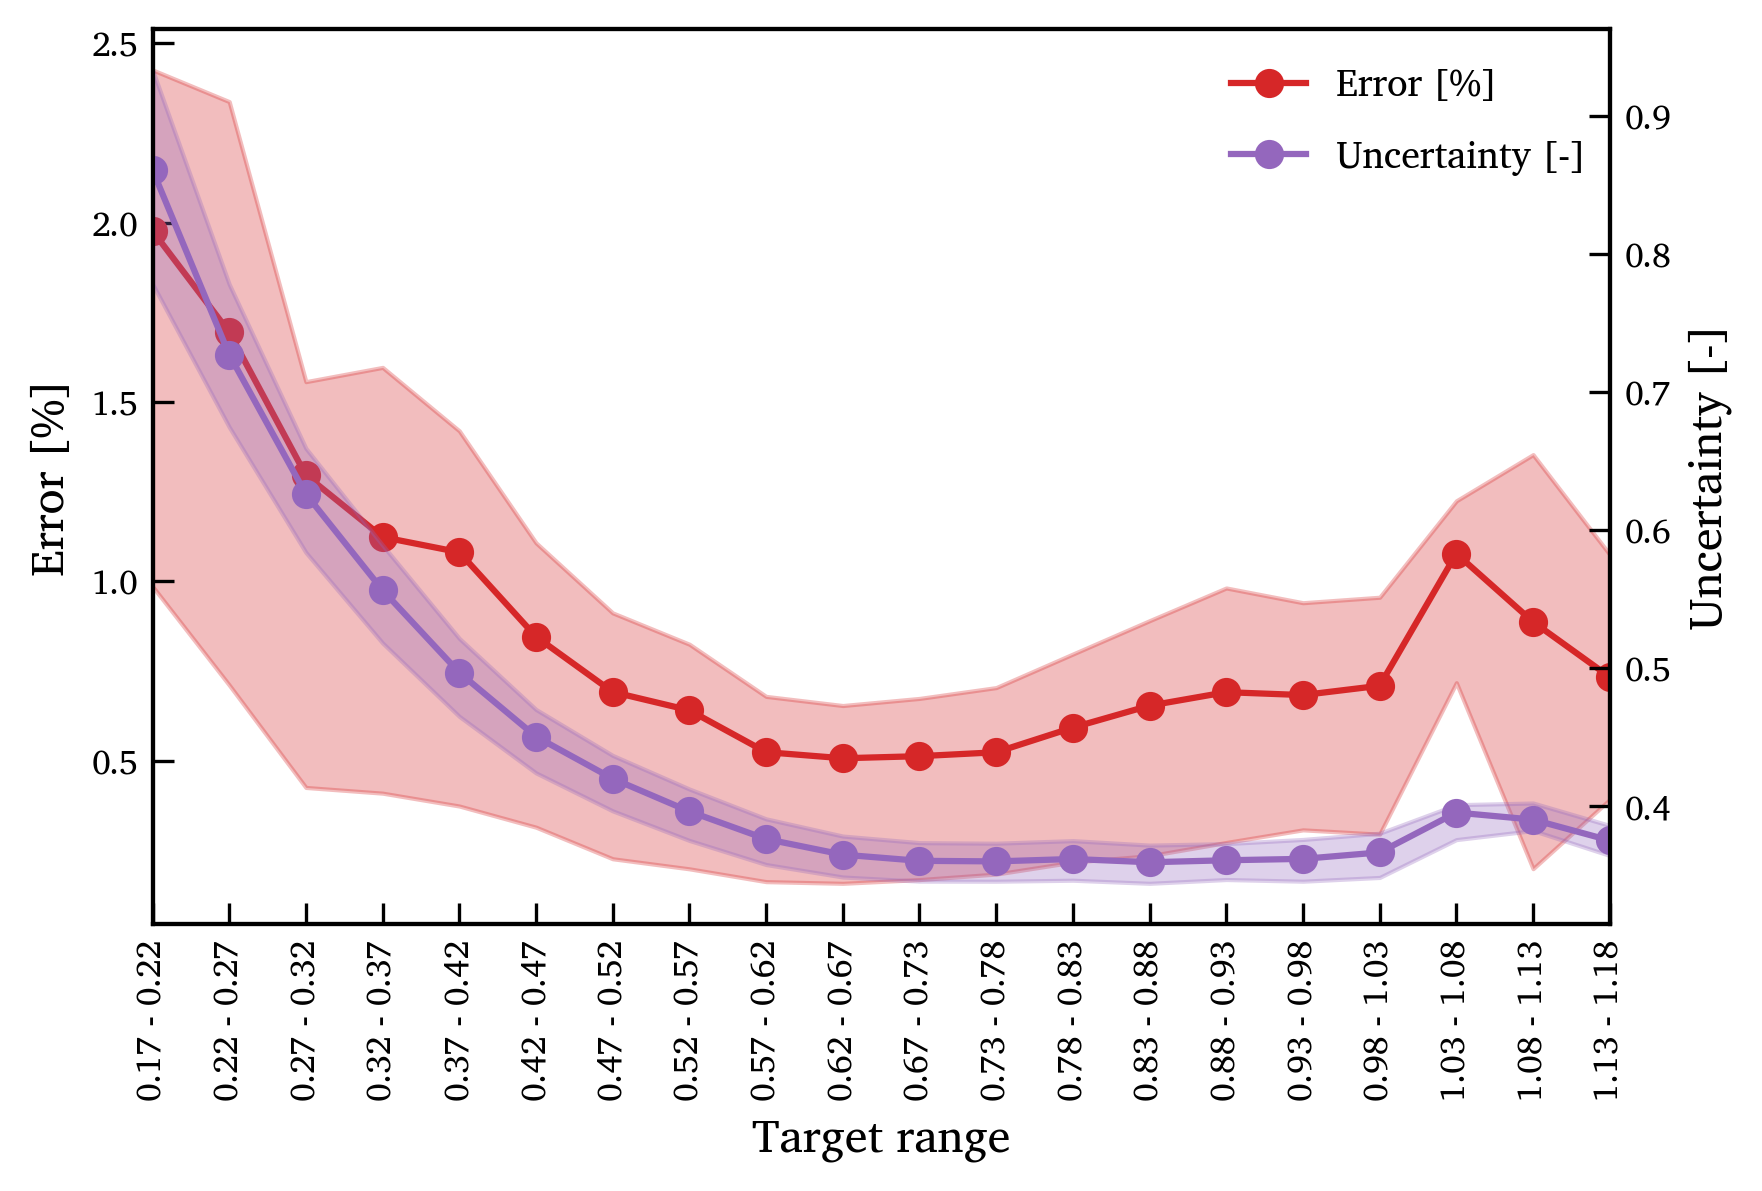

In [97]:
fig, ax1 = plt.subplots(figsize=plot_params.get_figsize(1.0))
ax2 = ax1.twinx()

counts, bins = np.histogram(y_true, bins=20)
x_vals = np.arange(len(counts))

error_means = []
error_lowers = []
error_uppers = []

uncertainty_means = []
uncertainty_lowers = []
uncertainty_uppers = []

for i in range(len(counts)):
    mask = np.logical_and(y_true >= bins[i], y_true < bins[i+1])

    error_bin = np.abs(relative_deviation)[mask]
    uncertainty_bin = uncertainty[mask]

    if len(error_bin) == 0 or len(uncertainty_bin) == 0:
        error_means.append(np.nan)
        error_lowers.append(np.nan)
        error_uppers.append(np.nan)
        uncertainty_means.append(np.nan)
        uncertainty_lowers.append(np.nan)
        uncertainty_uppers.append(np.nan)
        continue

    error_mean = error_bin.mean()
    uncertainty_mean = uncertainty_bin.mean()

    confidence = 50
    error_lower = np.percentile(error_bin, (100 - confidence) / 2)
    error_upper = np.percentile(error_bin, confidence + (100 - confidence) / 2)
    uncertainty_lower = np.percentile(uncertainty_bin, (100 - confidence) / 2)
    uncertainty_upper = np.percentile(uncertainty_bin, confidence + (100 - confidence) / 2)

    error_means.append(error_mean)
    error_lowers.append(error_lower)
    error_uppers.append(error_upper)
    uncertainty_means.append(uncertainty_mean)
    uncertainty_lowers.append(uncertainty_lower)
    uncertainty_uppers.append(uncertainty_upper)

# Plot Error with fill
ax1.plot(x_vals, error_means, 'o-', color=plot_params.colors[3], label='Error [%]')
ax1.fill_between(x_vals, error_lowers, error_uppers, color=plot_params.colors[3], alpha=0.3)

# Plot Uncertainty with fill
offset_x = x_vals
ax2.plot(offset_x, uncertainty_means, 'o-', color=plot_params.colors[4], label='Uncertainty [-]')
ax2.fill_between(offset_x, uncertainty_lowers, uncertainty_uppers, color=plot_params.colors[4], alpha=0.3)

ax1.set_xlabel('Target range')
ax1.set_ylabel('Error [%]')
ax2.set_ylabel('Uncertainty [-]')
ax1.set_xticks(x_vals)
ax1.set_xticklabels([f"{bins[i]:.2f} - {bins[i+1]:.2f}" for i in range(len(counts))], rotation=90)

ax1.legend(loc=[0.73, 0.9])
ax2.legend(loc=[0.73, 0.82])

plt.xlim([min(x_vals), max(x_vals)])
plt.show()


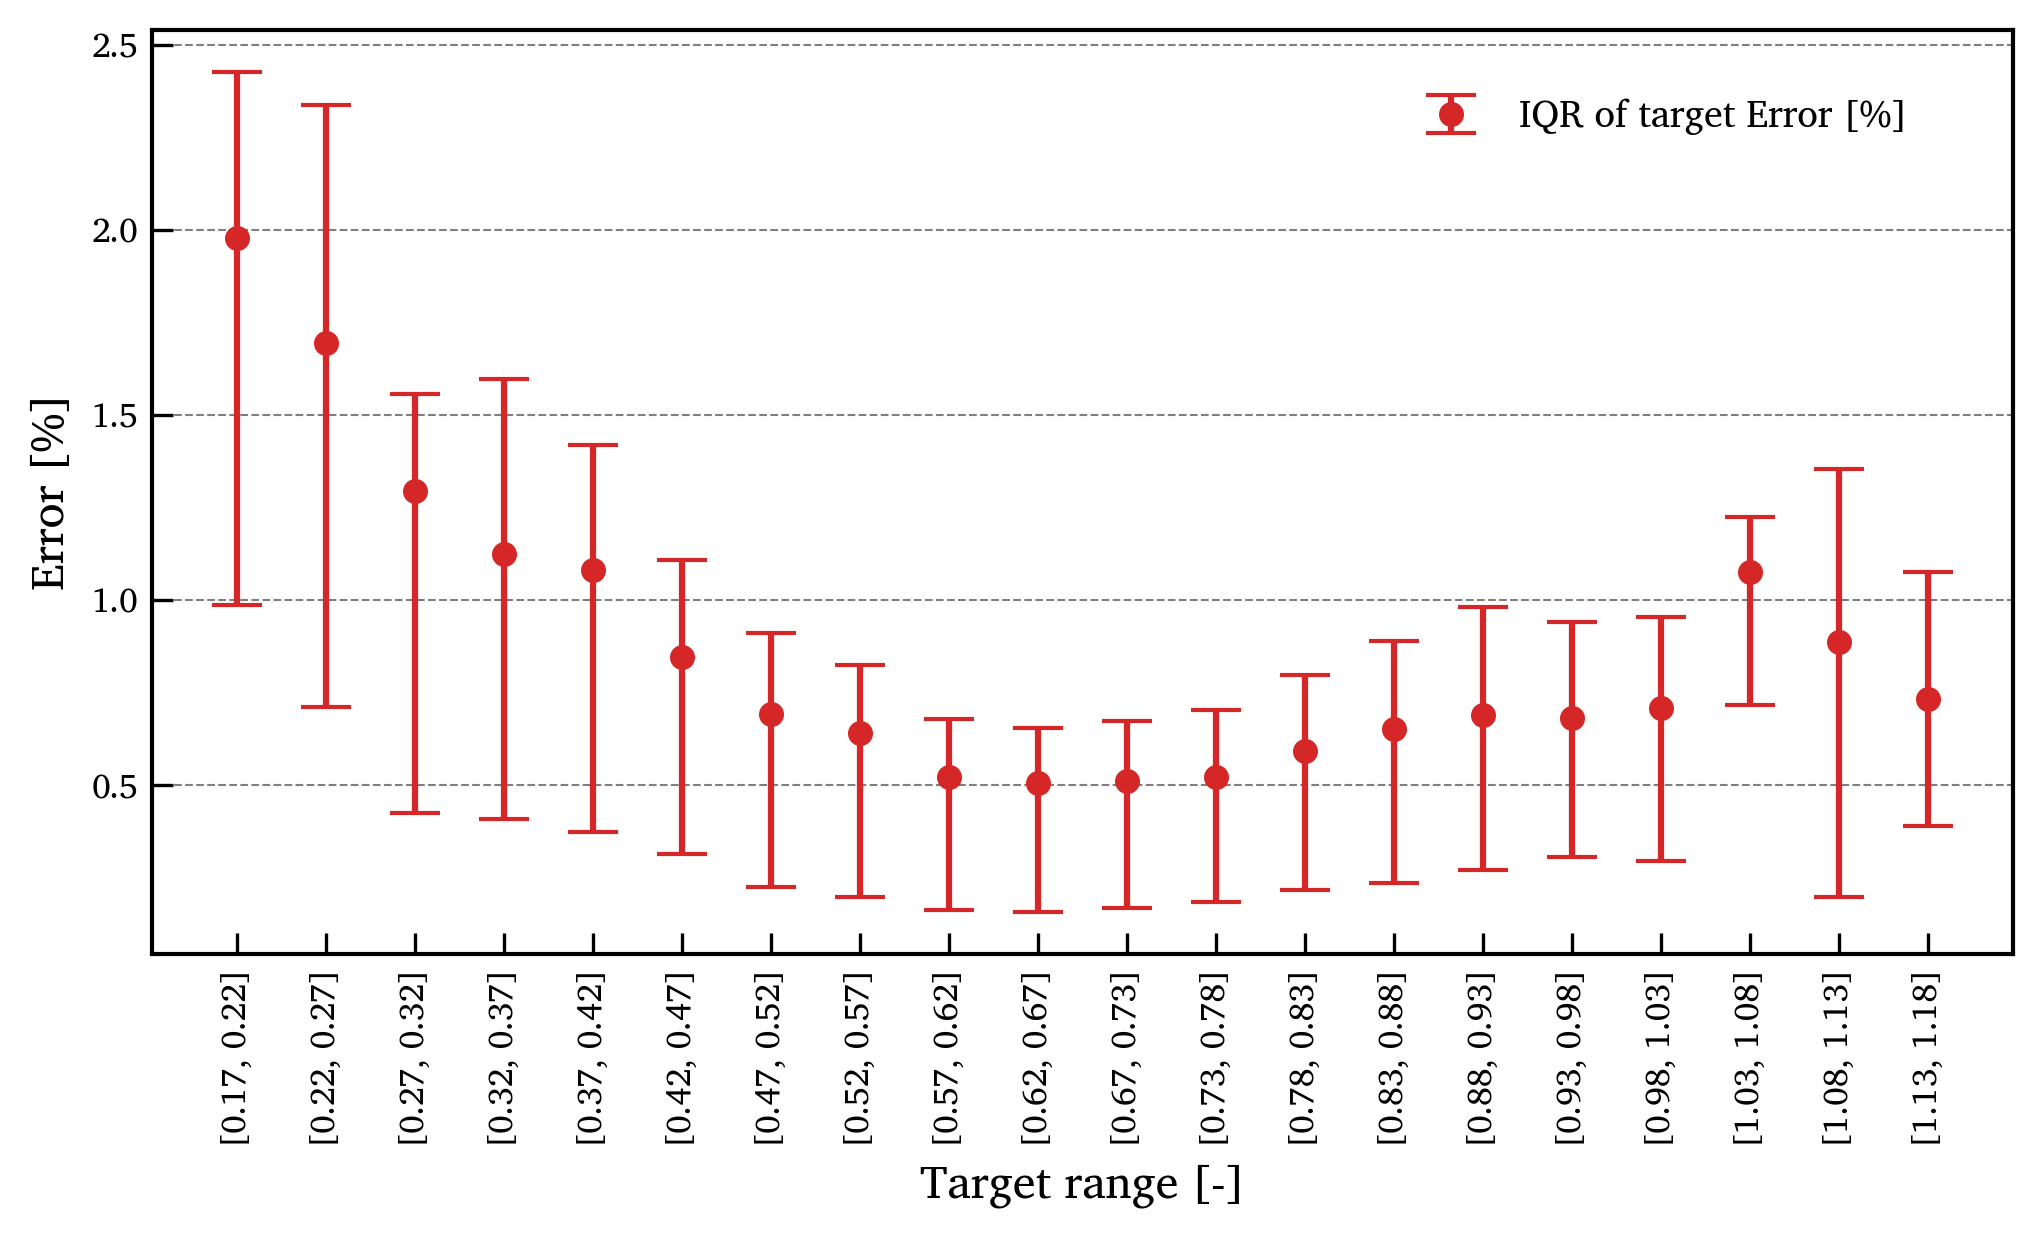

In [ ]:
fig, ax1 = plt.subplots(figsize=plot_params.get_figsize(1.0))

counts, bins = np.histogram(y_true, bins=20)

for i in range(len(counts)):
    mask = np.logical_and(y_true >= bins[i], y_true < bins[i+1])

    error_bin = np.abs(relative_deviation)[mask]

    error_bin_mean = error_bin.mean()

    confidence = 50
    error_lower_val = np.percentile(error_bin, (100 - confidence) / 2)
    error_upper_val = np.percentile(error_bin, confidence + (100 - confidence) / 2)

    error_lower_bound = error_bin_mean - error_lower_val
    error_upper_bound = error_upper_val - error_bin_mean

    error_bounds = np.array([[error_lower_bound], [error_upper_bound]])

    if i==0:
        label1='IQR of target Error [%]'
    else:
        label1=None
    ax1.errorbar(i, error_bin_mean, yerr=error_bounds, fmt='o', color=plot_params.colors[3], markersize=5, capsize=6,
                 label=label1)

ax1.set_xlabel('Target range [-]')
ax1.set_ylabel('Error [%]')
ax1.set_xticks(np.arange(len(counts)))
ax1.set_xticklabels([f"[{bins[i]:.2f}, {bins[i+1]:.2f}]" for i in range(len(counts))],rotation=90)
ax1.legend(loc=[0.67, 0.87])
plt.grid(True, axis='y', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)
plt.show()

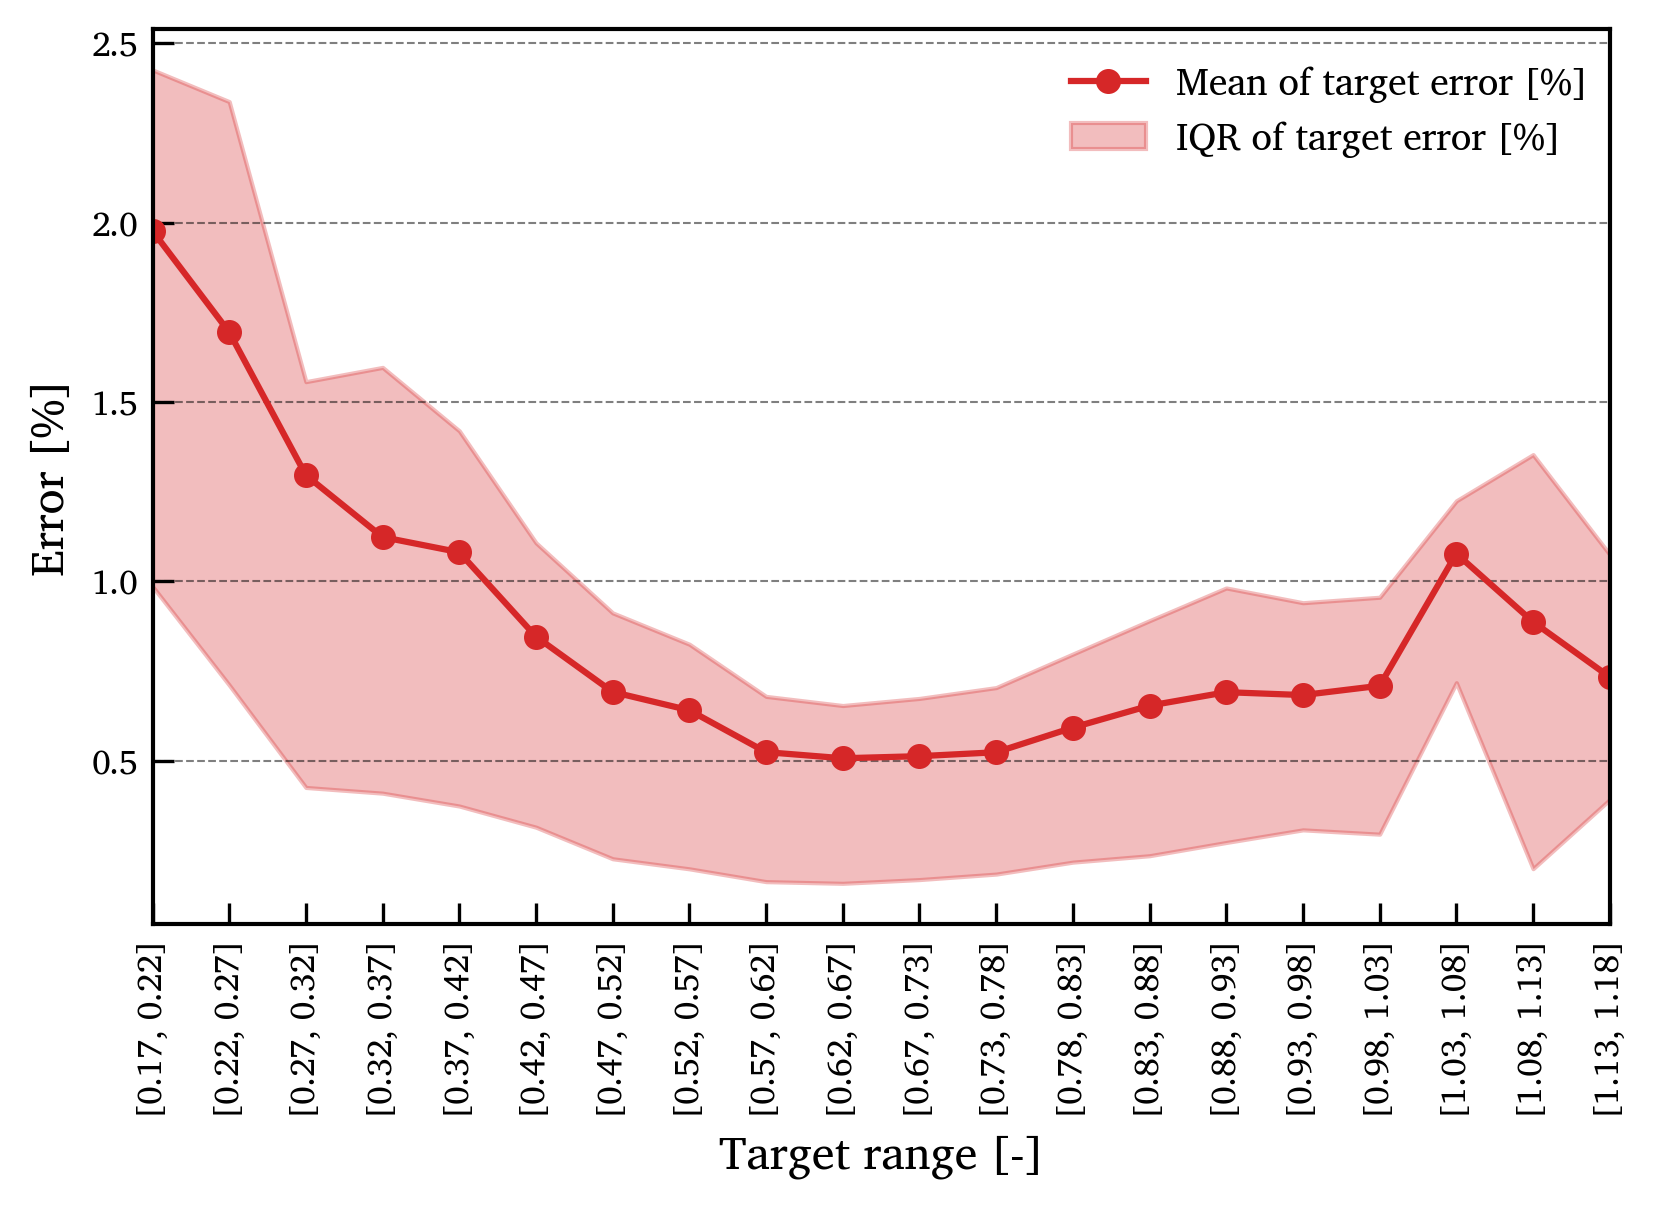

In [100]:
fig, ax1 = plt.subplots(figsize=plot_params.get_figsize(1.0))

counts, bins = np.histogram(y_true, bins=20)

x_vals = []
means = []
lowers = []
uppers = []

for i in range(len(counts)):
    mask = np.logical_and(y_true >= bins[i], y_true < bins[i+1])
    error_bin = np.abs(relative_deviation)[mask]
    if len(error_bin) == 0:
        continue
    error_bin_mean = error_bin.mean()
    confidence = 50
    error_lower_val = np.percentile(error_bin, (100 - confidence) / 2)
    error_upper_val = np.percentile(error_bin, confidence + (100 - confidence) / 2)
    error_lower_bound = error_bin_mean - error_lower_val
    error_upper_bound = error_upper_val - error_bin_mean

    x_vals.append(i)
    means.append(error_bin_mean)
    lowers.append(error_bin_mean - error_lower_bound)
    uppers.append(error_bin_mean + error_upper_bound)

ax1.plot(x_vals, means, color=plot_params.colors[3], marker='o', markersize=5, label='Mean of target error [%]')
ax1.fill_between(x_vals, lowers, uppers, color=plot_params.colors[3], alpha=0.3, label='IQR of target error [%]')

ax1.set_xlabel('Target range [-]')
ax1.set_ylabel('Error [%]')
ax1.set_xticks(np.arange(len(counts)))
ax1.set_xticklabels([f"[{bins[i]:.2f}, {bins[i+1]:.2f}]" for i in range(len(counts))], rotation=90)
ax1.legend(loc=[0.62, 0.84])
plt.xlim([min(x_vals), max(x_vals)])
plt.grid(True, axis='y', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)
plt.show()


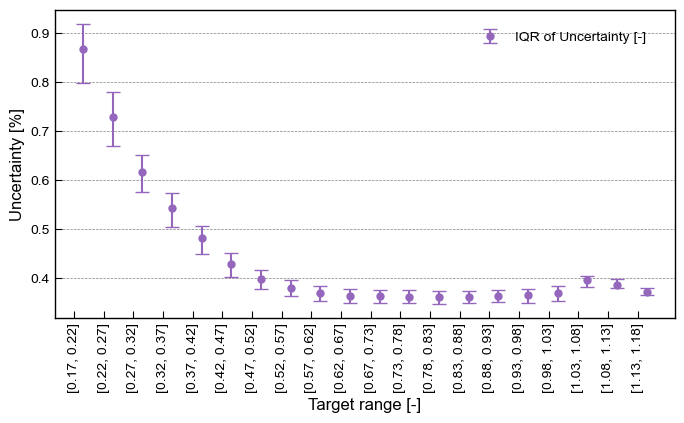

In [105]:
fig, ax1 = plt.subplots(figsize=(8,4))

counts, bins = np.histogram(y_true, bins=20)

for i in range(len(counts)):
    mask = np.logical_and(y_true >= bins[i], y_true < bins[i+1])

    uncertainty_bin = uncertainty[mask]

    uncertainty_bin_mean = uncertainty_bin.mean()

    confidence = 50
    uncertainty_lower_val = np.percentile(uncertainty_bin, (100 - confidence) / 2)
    uncertainty_upper_val = np.percentile(uncertainty_bin, confidence + (100 - confidence) / 2)

    uncertainty_lower_bound = uncertainty_bin_mean - uncertainty_lower_val
    uncertainty_upper_bound = uncertainty_upper_val - uncertainty_bin_mean

    uncertainty_bounds = np.array([[uncertainty_lower_bound], [uncertainty_upper_bound]])

    if i==0:
        label1='Error [%]'
        label2='IQR of Uncertainty [-]'
    else:
        label1=None
        label2=None
    ax1.errorbar(i+0.3, uncertainty_bin_mean, yerr=uncertainty_bounds, fmt='o', color=plot_params.colors[4], markersize=5, capsize=5,
                 label=label2)

ax1.set_xlabel('Target range [-]')
ax1.set_ylabel('Uncertainty [%]')
ax1.set_xticks(np.arange(len(counts)))
ax1.set_xticklabels([f"[{bins[i]:.2f}, {bins[i+1]:.2f}]" for i in range(len(counts))],rotation=90)
ax1.legend(loc=[0.67, 0.87])
plt.grid(True, axis='y', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)

plt.show()

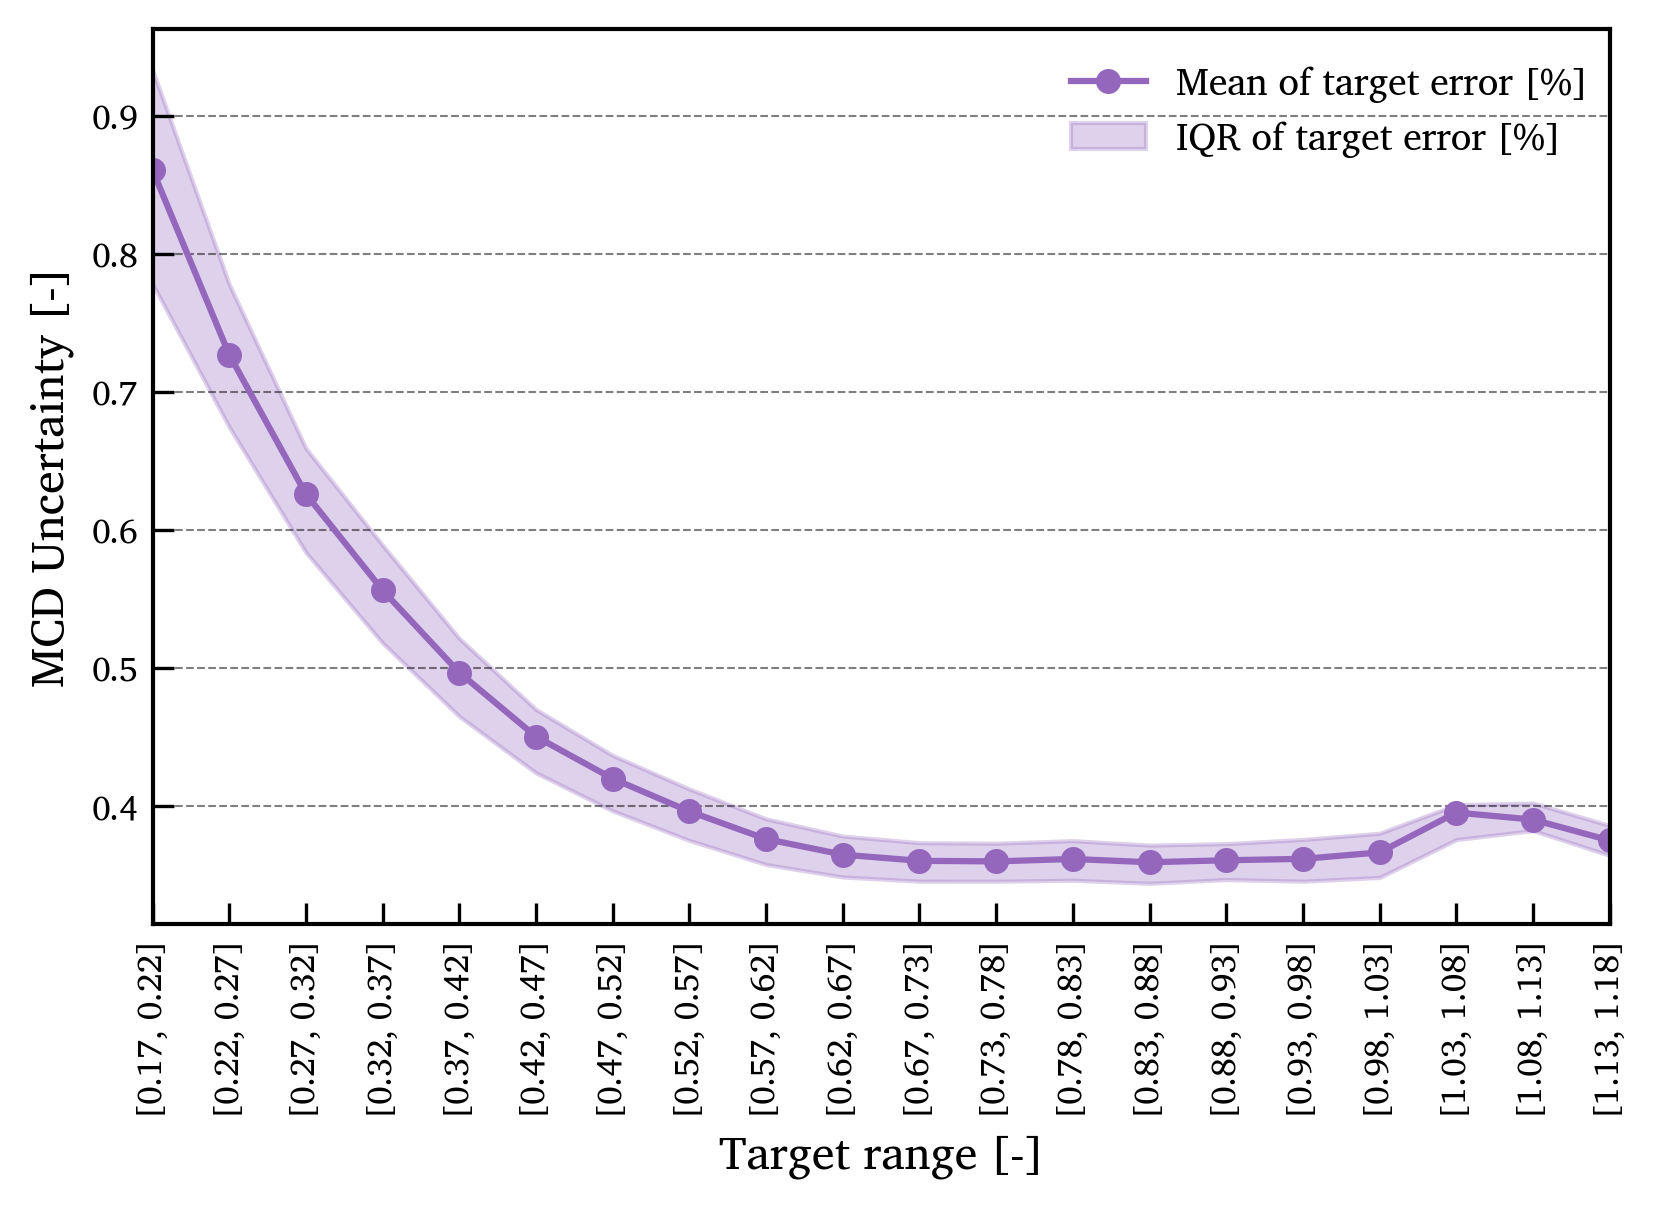

In [101]:
fig, ax1 = plt.subplots(figsize=plot_params.get_figsize(1.0))

counts, bins = np.histogram(y_true, bins=20)

x_vals = []
means = []
lowers = []
uppers = []

for i in range(len(counts)):
    mask = np.logical_and(y_true >= bins[i], y_true < bins[i+1])
    error_bin = np.abs(uncertainty)[mask]
    if len(error_bin) == 0:
        continue
    error_bin_mean = error_bin.mean()
    confidence = 50
    error_lower_val = np.percentile(error_bin, (100 - confidence) / 2)
    error_upper_val = np.percentile(error_bin, confidence + (100 - confidence) / 2)
    error_lower_bound = error_bin_mean - error_lower_val
    error_upper_bound = error_upper_val - error_bin_mean

    x_vals.append(i)
    means.append(error_bin_mean)
    lowers.append(error_bin_mean - error_lower_bound)
    uppers.append(error_bin_mean + error_upper_bound)

ax1.plot(x_vals, means, color=plot_params.colors[4], marker='o', markersize=5, label='Mean of target error [%]')
ax1.fill_between(x_vals, lowers, uppers, color=plot_params.colors[4], alpha=0.3, label='IQR of target error [%]')

ax1.set_xlabel('Target range [-]')
ax1.set_ylabel('MCD Uncertainty [-]')
ax1.set_xticks(np.arange(len(counts)))
ax1.set_xticklabels([f"[{bins[i]:.2f}, {bins[i+1]:.2f}]" for i in range(len(counts))], rotation=90)
ax1.legend(loc=[0.62, 0.84])
plt.xlim([min(x_vals), max(x_vals)])
plt.grid(True, axis='y', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)
plt.show()

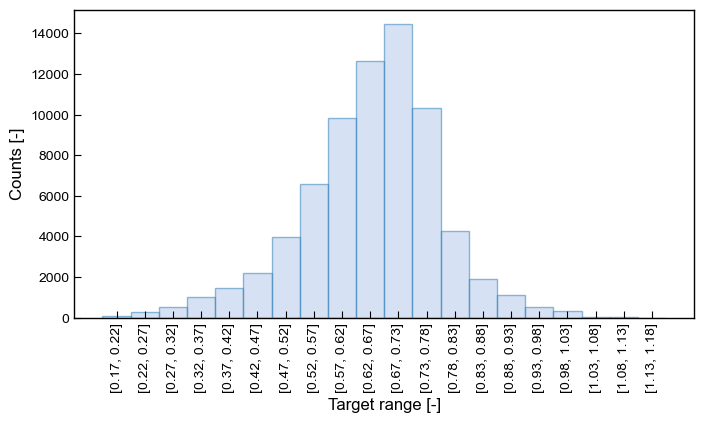

In [106]:
fig, ax1 = plt.subplots(figsize=(8,4))

counts, bins = np.histogram(y_true, bins=20)
bins_mid = bins[:-1] + (bins[1]-bins[0])/2

plt.hist(y_true, bins=20, alpha=0.5, 
         color=plot_params.morecolors[1], 
         edgecolor=plot_params.morecolors[0],
         linewidth=1.0,
         label='Data points')

plt.ylabel('Counts [-]')
plt.xlabel('Target range [-]')
plt.xticks(bins_mid,[f"[{bins[i]:.2f}, {bins[i+1]:.2f}]" for i in range(len(counts))],rotation=90)
plt.show()

The larger error and uncertainty for _small_ predicted targets can partly be explained by _sparsity_ of the training data for these values. However, looking at the graph below, the predictions for _large_ targets also have _sparse_ training data but seem to be much more _reliable_.

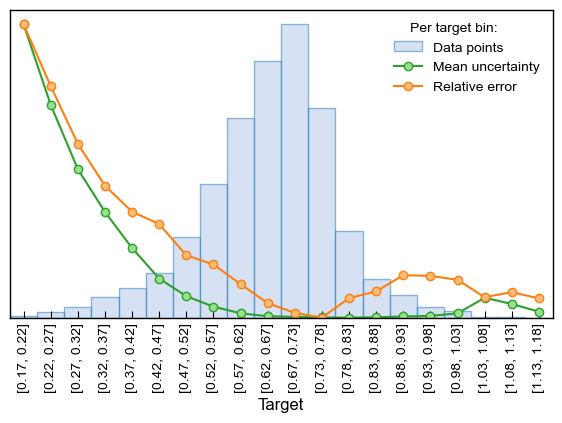

In [40]:
fig, ax = plt.subplots(figsize=(7,4))   

plt.hist(y_true, bins=20, alpha=0.5, 
         color=plot_params.morecolors[1], 
         edgecolor=plot_params.morecolors[0],
         linewidth=1.0,
         label='Data points')

counts, bins = np.histogram(y_true, bins=20)
bins_mid = bins[:-1] + (bins[1]-bins[0])/2

uncertainty_means = []
for i in range(len(counts)):
    mask = np.logical_and(y_true >= bins[i], y_true < bins[i+1])
    uncertainty_bin = uncertainty[mask]
    uncertainty_bin_mean = uncertainty_bin.mean()
    uncertainty_means.append(uncertainty_bin_mean)
uncertainty_means = (np.array(uncertainty_means)-np.min(uncertainty_means)) / (np.max(uncertainty_means)-np.min(uncertainty_means)) * counts.max()

plt.plot(bins_mid,uncertainty_means,
         marker='o',
         markerfacecolor=plot_params.morecolors[5],
         markeredgecolor=plot_params.morecolors[4],
         color=plot_params.morecolors[4], 
         label='Mean uncertainty')

error_means = []
for i in range(len(counts)):
    mask = np.logical_and(y_true >= bins[i], y_true < bins[i+1])
    error_bin = np.abs(relative_deviation)[mask]
    error_bin_mean = error_bin.mean()
    error_means.append(error_bin_mean)
error_means = (np.array(error_means)-np.min(error_means)) / (np.max(error_means)-np.min(error_means)) * counts.max()
plt.plot(bins_mid,error_means,
         marker='o',
         markerfacecolor=plot_params.morecolors[3],
         markeredgecolor=plot_params.morecolors[2],
         color=plot_params.morecolors[2], 
         label='Relative error')

plt.legend(title='Per target bin:       ')
plt.xlim([min(y_true),max(y_true)])
plt.yticks([])
plt.ylabel('')

plt.xlabel('Target')
plt.xticks(bins_mid,[f"[{bins[i]:.2f}, {bins[i+1]:.2f}]" for i in range(len(counts))],rotation=90)
plt.show()

**Effect of data sparsity on error & uncertainty**

For each target bin, get the amount of data and the mean error & uncertainty.

In [47]:
df_test = df_full.loc[model.data['test_data']]

In [48]:
n_bins = 50
target_true_counts, target_true_bins = np.histogram(y_true,bins=n_bins)
target_true_bins_mid = target_true_bins[:-1] + np.diff(target_true_bins) / 2

uncertainty_counts, uncertainty_bins = np.histogram(uncertainty,bins=n_bins)

uncertainty_bins_means = np.zeros(len(target_true_bins)-1)
uncertainty_bins_var = np.zeros(len(target_true_bins)-1)

features_bin = {feature: np.zeros(len(target_true_bins)-1) for feature in model.features}

for i in range(len(uncertainty_counts)):
    mask = (y_true >= target_true_bins[i]) & (y_true < target_true_bins[i+1])
    uncertainty_bins_means[i] = np.mean(uncertainty[mask])
    uncertainty_bins_var[i] = np.var(uncertainty[mask])

    for feature in model.features:
        features_bin[feature][i] = np.mean(df_test.loc[mask, feature])

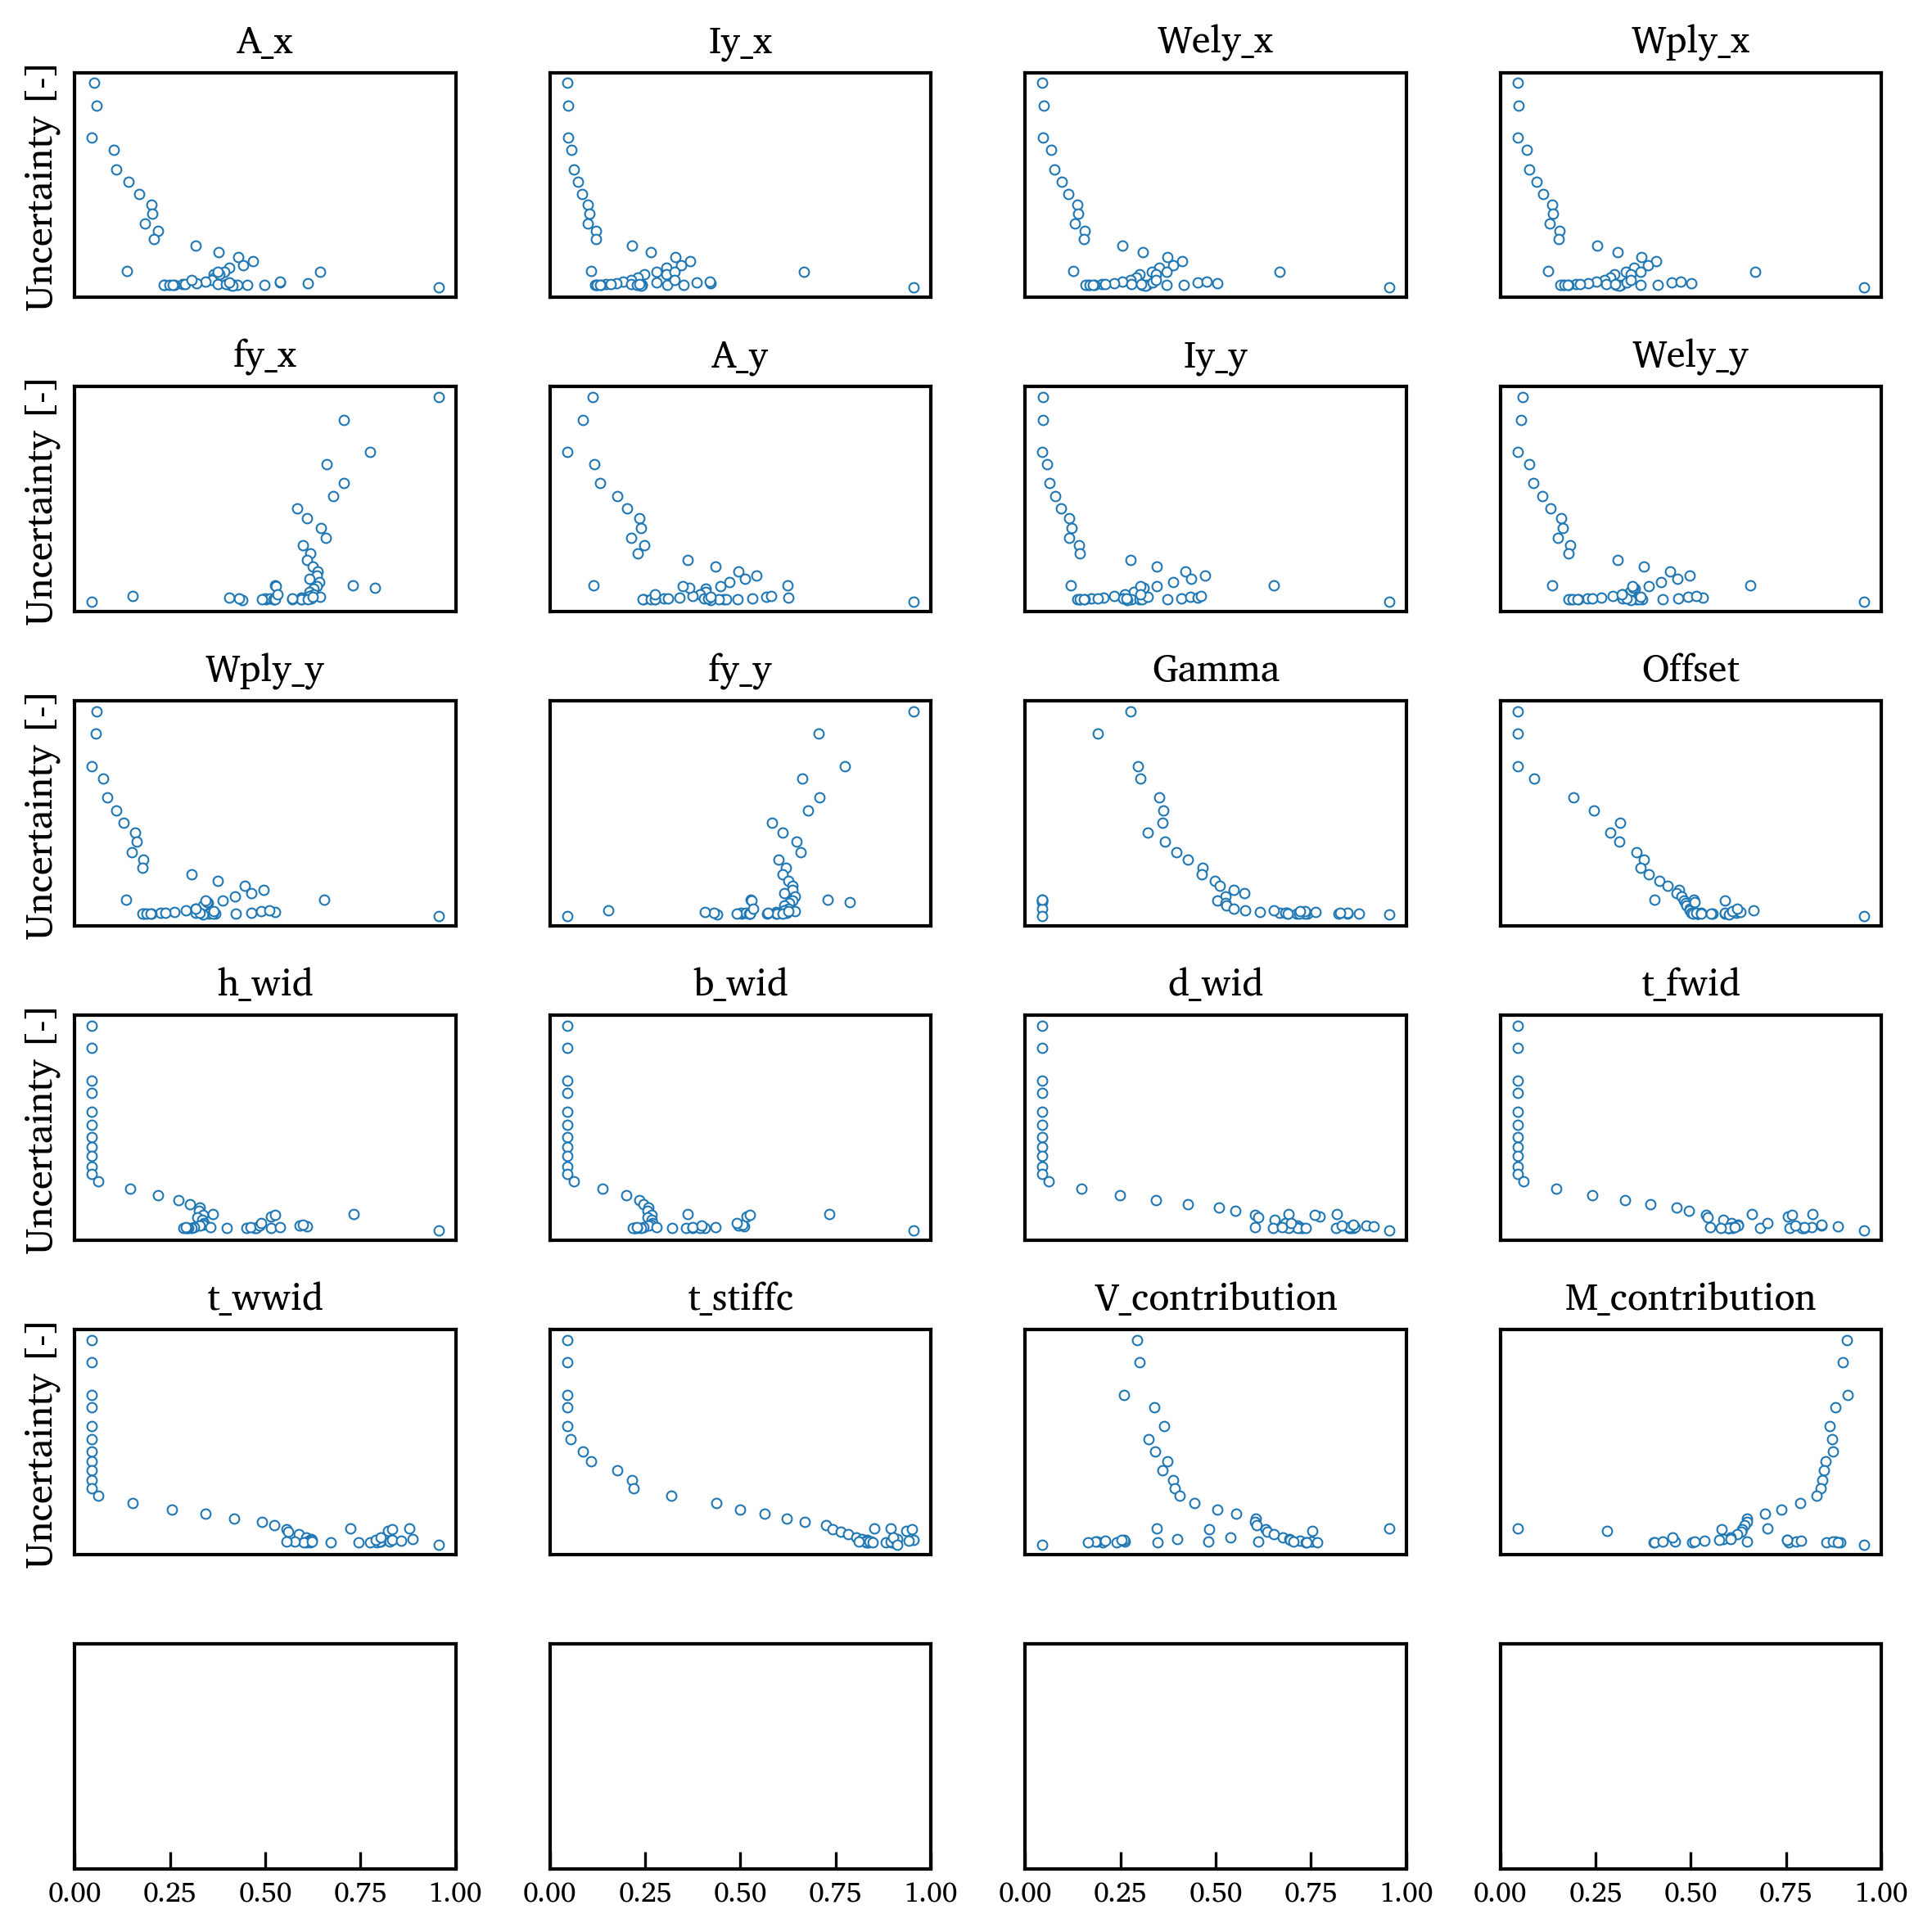

In [49]:
fig, axs = plt.subplots(int(len(model.features)/4)+1,4, figsize=(8,8), sharey=True)

for i, feature in enumerate(model.features):
    ax = axs[int(i/4), i%4]
    ax.scatter(features_bin[feature], uncertainty_bins_means, 
               s=8, 
               edgecolor=plot_params.morecolors[0],
               linewidth=0.5,
               facecolor='white')
    ax.set_title(feature)
    ax.set_xticks([])
    ax.set_yticks([])

for i in range(5):
    axs[i,0].set_ylabel('Uncertainty [-]')

plt.tight_layout()
plt.show()

Bin the **true targets** and find for each bin the number of elements per bin ($N_{\text{bin}}$). For all elements in a **bin** find the **mean** of its **uncertainty** ($\mu_{\text{uncertainty,bin}}$). Then try to find a visual correlation between $\mu_{\text{uncertainty,bin}}$ and $N_{\text{bin}}$. The goal is to understand if uncertainty of a given predicted target range (=bin), correlates to the number of samples available. It would be common sense to see bins with few samples $N_{\text{bin}}$ to have larger uncertainty $\mu_{\text{uncertainty,bin}}$.

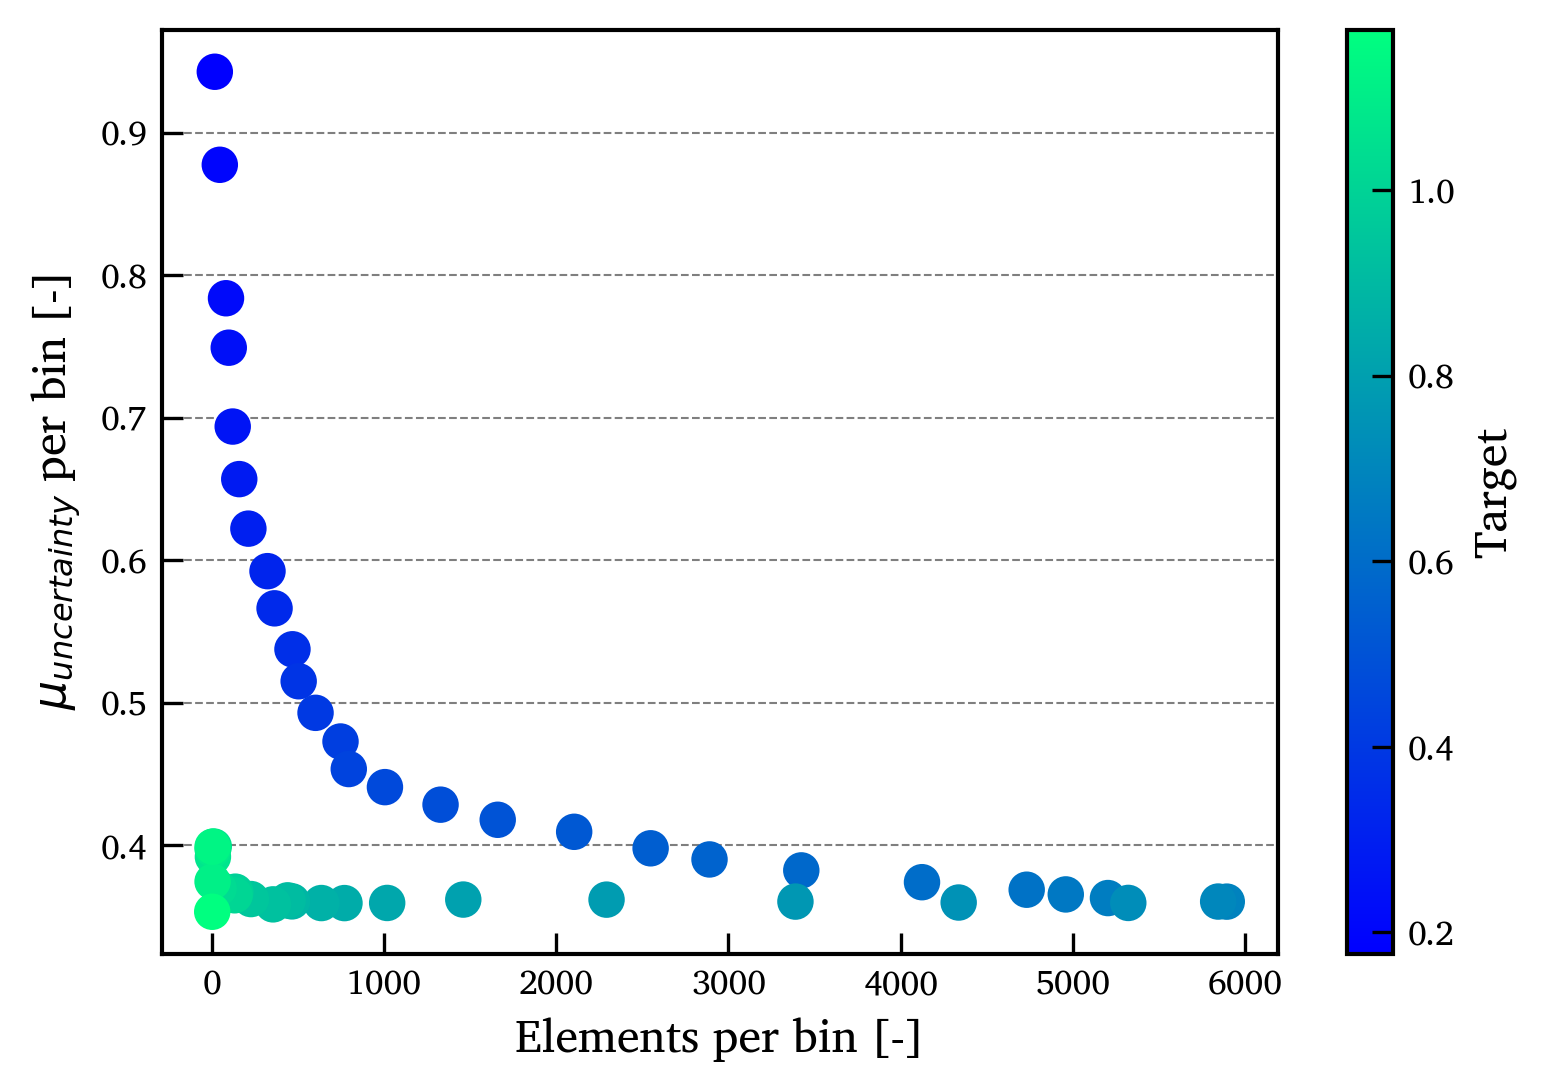

In [50]:
fig, ax = plt.subplots(figsize=(6,4))
plt.scatter(target_true_counts,uncertainty_bins_means,
            s=60, 
            c=target_true_bins_mid,
            cmap='winter',
            zorder=2)
plt.ylabel("$\mu_{uncertainty}$ per bin [-]")
plt.xlabel("Elements per bin [-]")

plt.colorbar(label='Target')

plt.grid(True, axis='y', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)

plt.show()

As indicated there is a strong relation between $\mu_{\text{uncertainty,bin}}$ and $N_\text{bin}$. Bins with few elements either tend to have a very small **OR** large uncertainty. This depends on the target of the bin. It can be said that:

- Bins with **few** values and a **small** true target, have a small uncertainty $\mu_{\text{uncertainty,bin}}$

- Bins with **few** values and a **large** true target, have a large uncertainty $\mu_{\text{uncertainty,bin}}$


Few samples lead to larger variation, hence larger uncertainty. But how does the target decides on wheter the uncertainty is high or low?

There is no linear relation between the **true target** and the **uncertainty**, but there is a tendency for a **large** true target to be **more** **uncertain**.

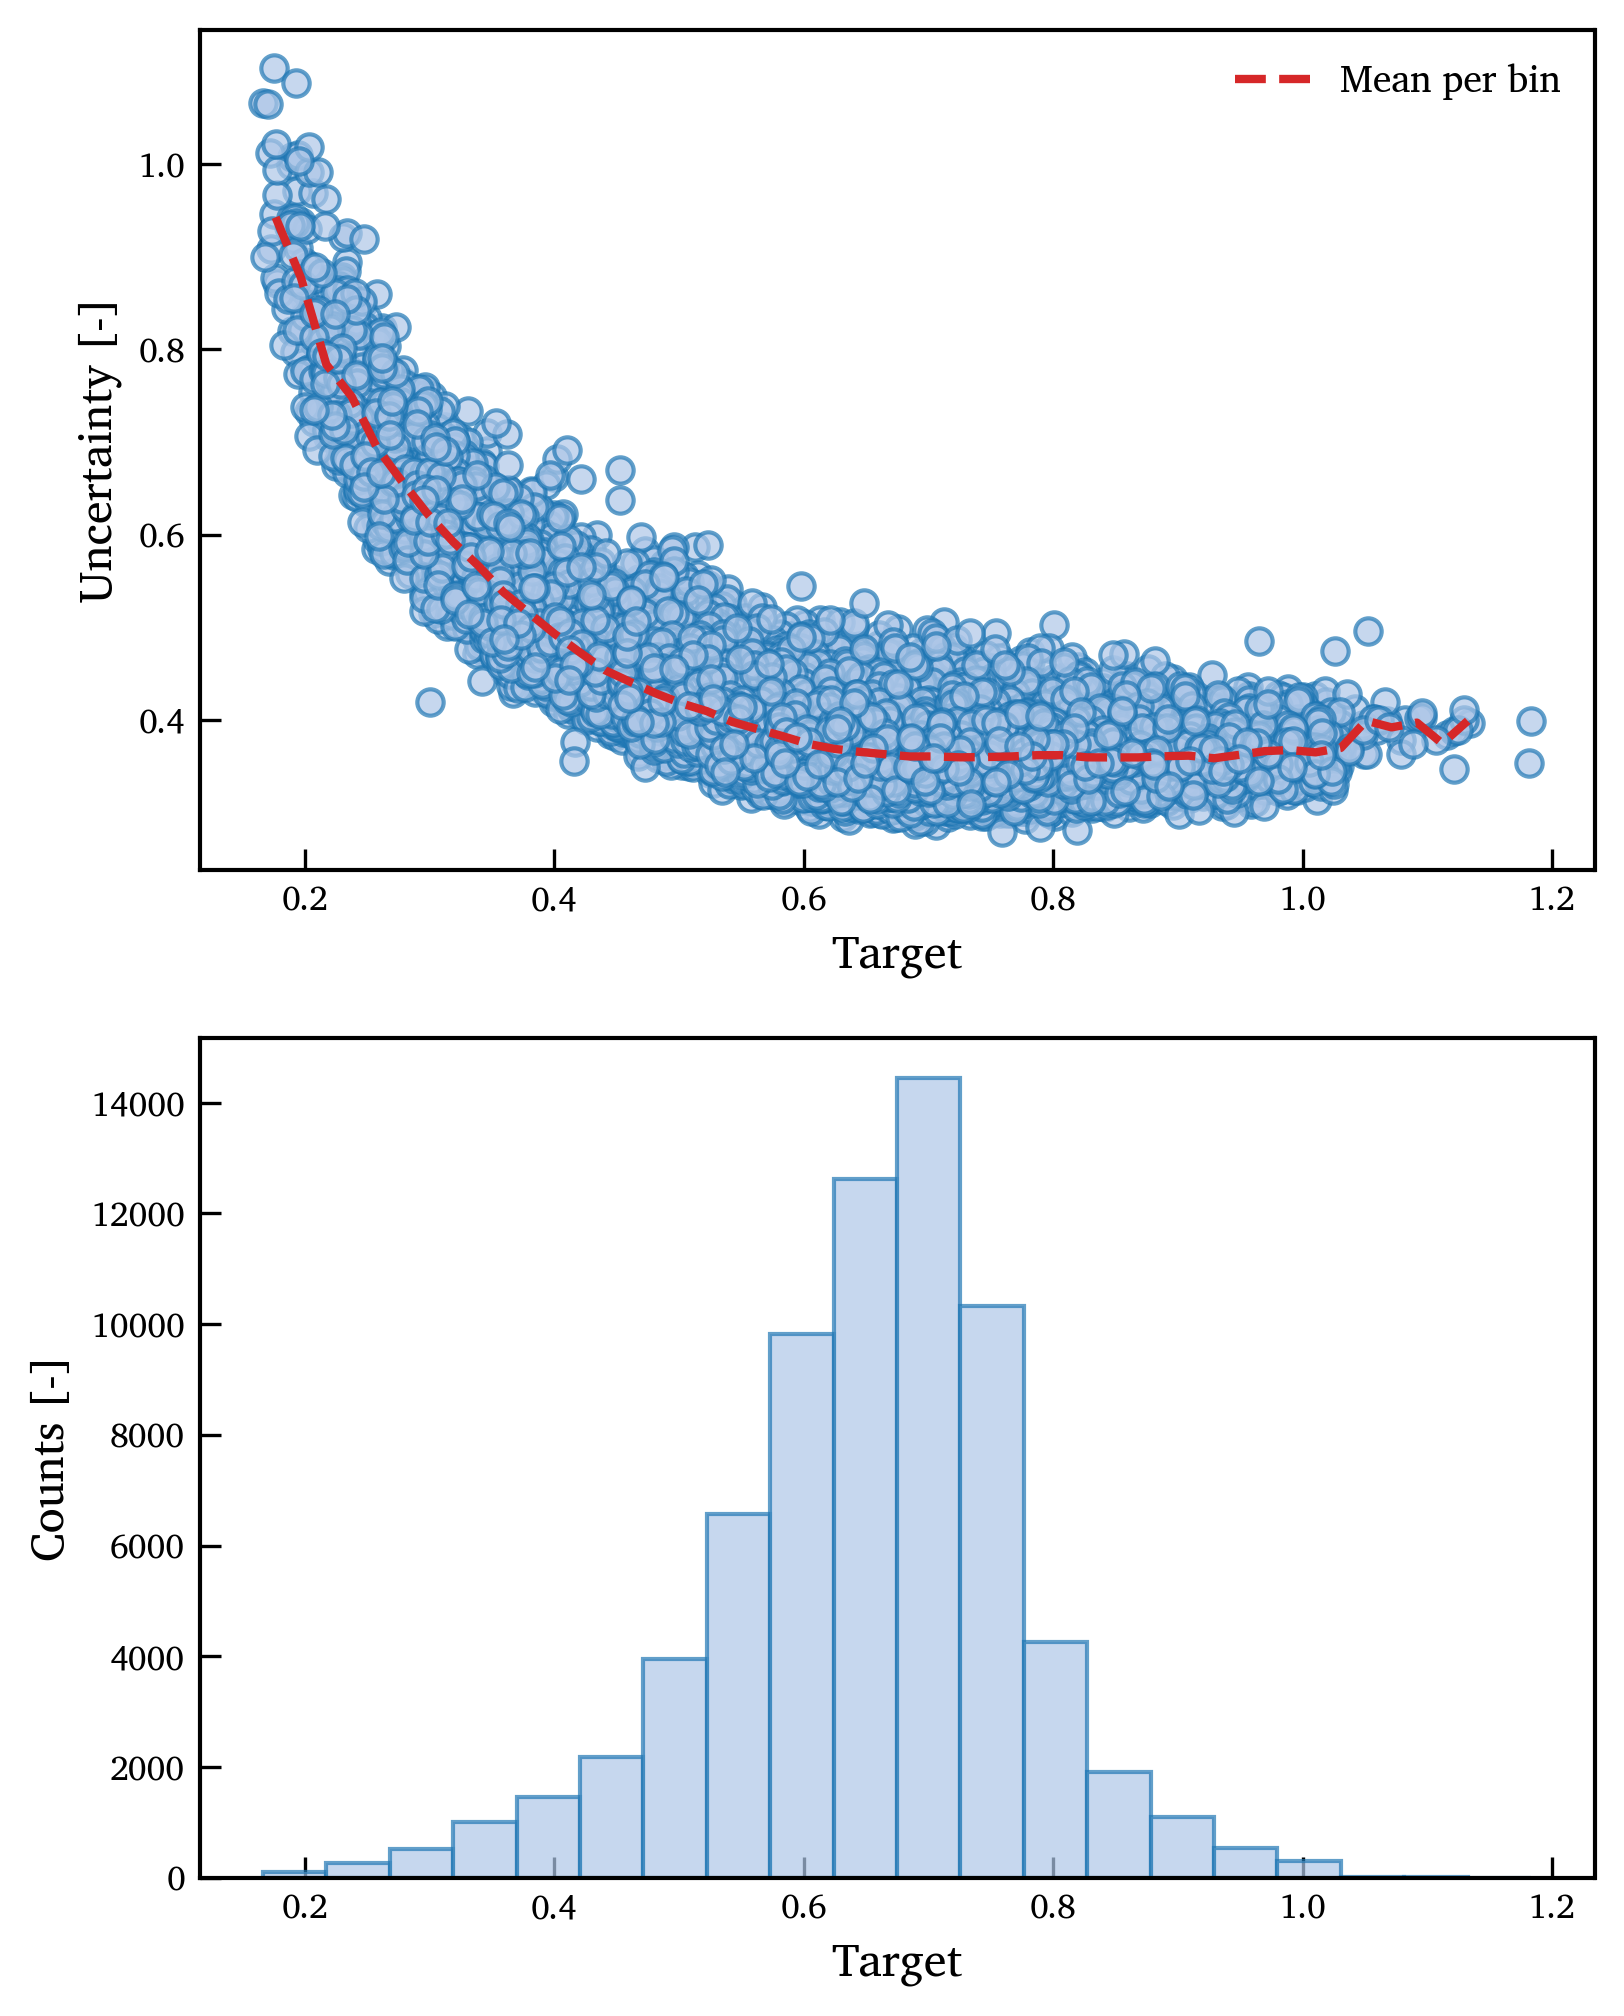

In [51]:
fig, axs = plt.subplots(2,1, figsize=(6, 8))

axs[0].scatter(y_true, uncertainty, 
               s=40, facecolor=plot_params.morecolors[1],
                edgecolors=plot_params.morecolors[0],
                linewidth=1.0, alpha=0.7, zorder=2)

axs[0].plot(target_true_bins_mid,uncertainty_bins_means,
            c=plot_params.colors[3],
            linewidth=2.0,
            linestyle='--',
            label='Mean per bin'
            )

axs[1].hist(y_true, facecolor=plot_params.morecolors[1],
               edgecolor=plot_params.morecolors[0], 
               linewidth=1.0, 
               alpha=0.7, zorder=2, 
               bins=20, 
               label='True Target')

axs[0].set_xlabel("Target")
axs[0].set_ylabel("Uncertainty [-]")

axs[1].set_xlabel("Target")
axs[1].set_ylabel("Counts [-]")

axs[0].legend()

plt.show()

#### MC Mean, Standard Deviation, Variance

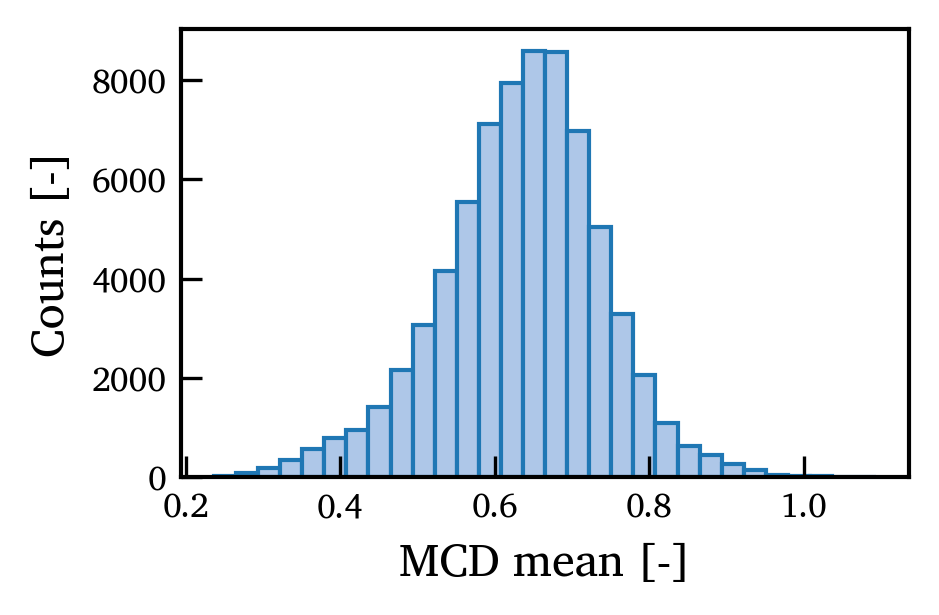

In [62]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.5))

_ = plt.hist(mcd_mean, 
             bins=30, 
             facecolor=plot_params.morecolors[1],
             edgecolor=plot_params.morecolors[0])
plt.xlabel('MCD mean [-]')
plt.ylabel('Counts [-]')

plt.show()

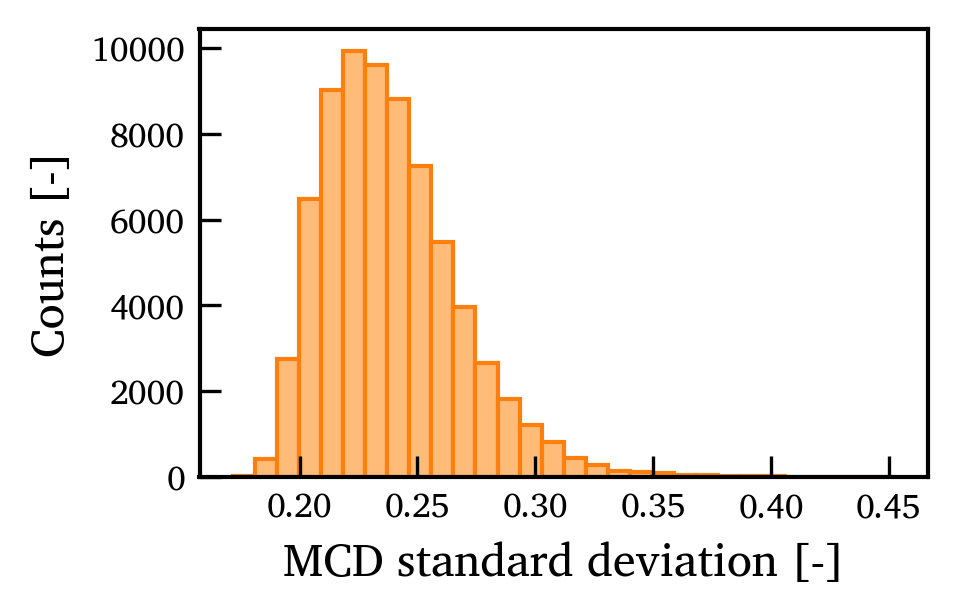

In [64]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.5))

_ = plt.hist(mcd_std, 
             bins=30, 
             facecolor=plot_params.morecolors[3],
             edgecolor=plot_params.morecolors[2])
plt.xlabel('MCD standard deviation [-]')
plt.ylabel('Counts [-]')

plt.show()

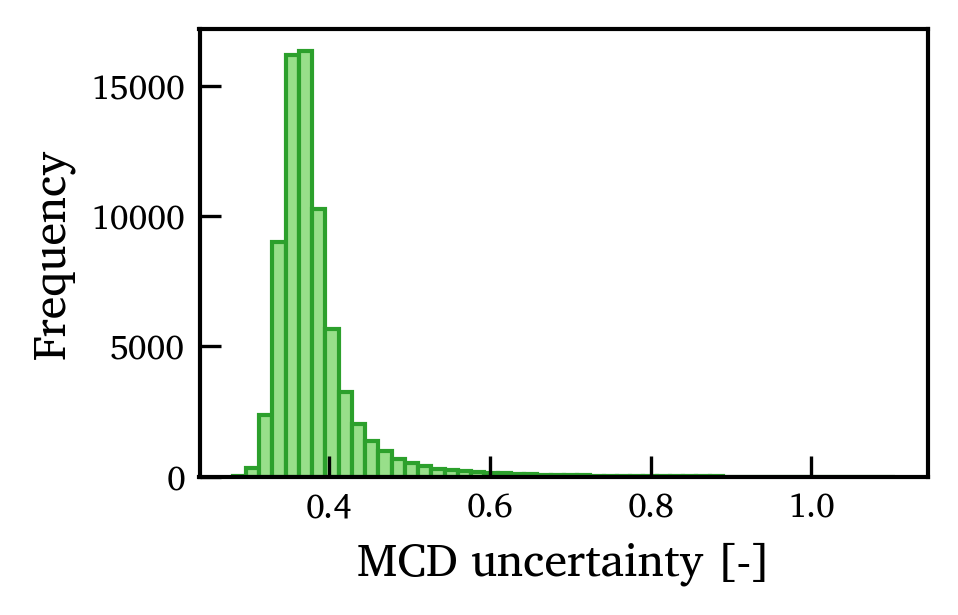

In [68]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.5))

_ = plt.hist(uncertainty, 
             bins=50, 
             facecolor=plot_params.morecolors[5],
             edgecolor=plot_params.morecolors[4])
plt.xlabel('MCD uncertainty [-]')
plt.ylabel('Frequency')

plt.show()

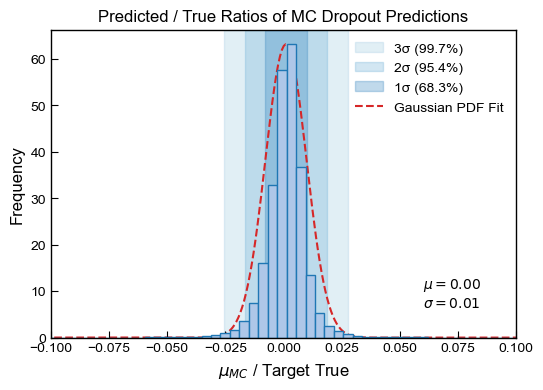

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

counts, bins, _ = plt.hist(
    relative_error.flatten(), bins=200, density=True, 
    facecolor=plot_params.morecolors[1], edgecolor=plot_params.morecolors[0], alpha=1.0, zorder=2
)

mu, sigma = np.mean(relative_error.flatten()), np.std(relative_error.flatten())
x = np.linspace(min(relative_error.flatten()), max(relative_error.flatten()), 1000)
gaussian_curve = norm.pdf(x, mu, sigma)

gaussian_curve *= max(counts) / max(gaussian_curve)

ymin, ymax = 0, max(counts) * 1.1
ax.axvspan(mu - 3*sigma, mu + 3*sigma, alpha=0.3, color=plt.cm.tab20c.colors[2], label='3σ (99.7%)', zorder=0)
ax.axvspan(mu - 2*sigma, mu + 2*sigma, alpha=0.3, color=plt.cm.tab20c.colors[1], label='2σ (95.4%)', zorder=0)
ax.axvspan(mu - 1*sigma, mu + 1*sigma, alpha=0.3, color=plt.cm.tab20c.colors[0], label='1σ (68.3%)', zorder=0)

plt.xlim([-0.1,0.1])

plt.plot(x, gaussian_curve, c=plot_params.colors[3], 
         linewidth=1.5, 
         linestyle='--',
         label='Gaussian PDF Fit',
         zorder=1)

plt.xlabel('$\mu_{MC}$ - Target')
plt.ylabel('Frequency')
plt.title('Predicted / True Ratios of MC Dropout Predictions')

plt.annotate('$\mu= {:.2f}$\n$\sigma= {:.2f}$'.format(mu, sigma), 
             xy=(0.8, 0.1), xycoords='axes fraction')

plt.legend()
plt.show()

Each _violon_ represents the distribution of the target predictions of the test set of one MC dropout sample.

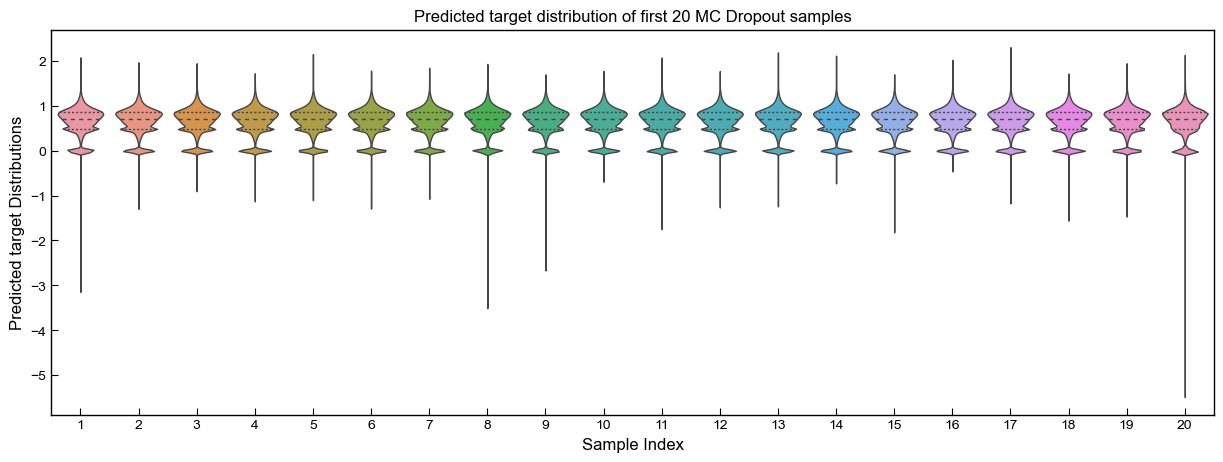

In [ ]:
m = 20  
subset_predictions = preds_mc_dropout[:m]
data = [subset_predictions[i] for i in range(m)]

plt.figure(figsize=(15, 5))
sns.violinplot(data=data, inner="quartile", linewidth=1)

plt.xlabel("Sample Index")
plt.ylabel("Predicted target Distributions")
plt.title(f"Predicted target distribution of first {m} MC Dropout samples")

plt.xticks(ticks=range(m), labels=[f"{i+1}" for i in range(m)])

plt.show()

### Clustering Features

In [65]:
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(model.x_test.numpy())

In [66]:
def get_cluster_stats(X, labels):
    df = pd.DataFrame(X)
    df['cluster'] = labels
    means = df.groupby('cluster').mean().drop(columns='cluster', errors='ignore')
    variances = df.groupby('cluster').var().drop(columns='cluster', errors='ignore')
    return means, variances

means, variances = get_cluster_stats(model.x_test.numpy(), clusters)

In [67]:
def plot_all_features_violin(X, labels, model):
    m = np.max(labels) + 1
    n_features = X.shape[1]
    
    fig, axes = plt.subplots(nrows=n_features, figsize=(10, 3 * n_features))
    if n_features == 1:
        axes = [axes]

    for feature_idx in range(n_features):
        data = []
        for k in range(m):
            for val in X[labels == k, feature_idx]:
                data.append((k, val))
        df = pd.DataFrame(data, columns=["Cluster", "Value"])

        sns.violinplot(x="Cluster", y="Value", data=df, ax=axes[feature_idx], linewidth=0.5, palette='Set2')
        axes[feature_idx].set_title(f'Feature {model.features[feature_idx]} Distribution per Cluster')
        axes[feature_idx].set_xlabel('')
        axes[feature_idx].set_ylabel('')

    plt.tight_layout()
    plt.show()


### Cluster Distributions

Feature distributions of the resulting clusters

In [63]:
plot_all_features_violin(model.x_test.numpy(), clusters, model)

NameError: name 'plot_all_features_violin' is not defined

In [ ]:
cluster_uncertainty = np.array([np.mean(uncertainty[clusters==i]) for i in np.unique(clusters)])

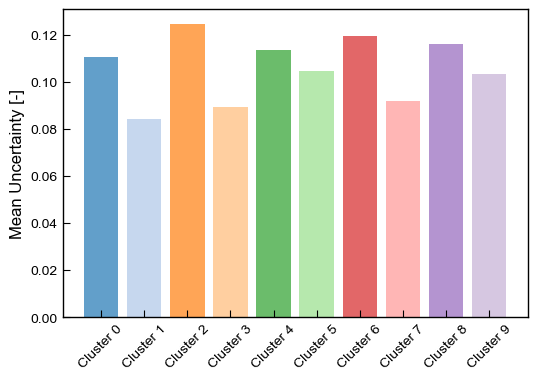

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

plt.bar(np.arange(len(cluster_uncertainty)), cluster_uncertainty,
        color=plot_params.morecolors[:len(cluster_uncertainty)], 
        linewidth=0.5, alpha=0.7)

plt.xticks(np.arange(len(cluster_uncertainty)), 
           [f"Cluster {i}" for i in np.unique(clusters)],
           rotation=45)

plt.ylabel('Mean Uncertainty [-]')

plt.show()

### Uncertainty Analysis

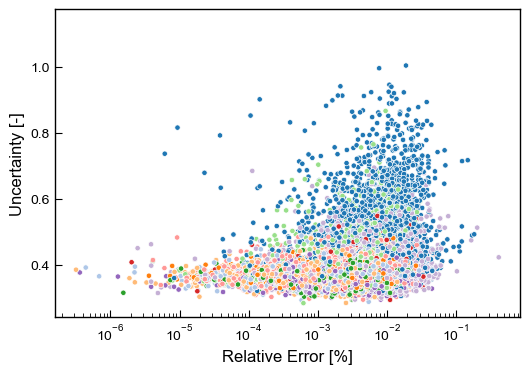

In [68]:
fig, ax = plt.subplots(figsize=(6,4))

plt.scatter(relative_error, uncertainty,
            s=15, 
            facecolor=np.array(plot_params.morecolors)[clusters], 
            edgecolors='white',
            linewidth=0.5,
            zorder=1)

plt.xscale('log')

plt.xlabel("Relative Error [%]")
plt.ylabel("Uncertainty [-]")

plt.show()

In [69]:
rel_error_bins = np.array([10**(i) for i in np.linspace(-8,0,12)])
rel_error_bins_mid = rel_error_bins[:-1] + np.diff(rel_error_bins) / 2

uncertainty_bins_means = np.zeros(len(rel_error_bins)-1)
uncertainty_bins_var = np.zeros(len(rel_error_bins)-1)
uncertainty_bins_values = [None] * (len(rel_error_bins)-1)
for i in range(len(rel_error_bins_mid)):
    mask = (relative_error >= rel_error_bins[i]) & (relative_error < rel_error_bins[i+1])
    uncertainty_bins_means[i] = np.mean(uncertainty[mask])
    uncertainty_bins_var[i] = np.var(uncertainty[mask])
    uncertainty_bins_values[i] = uncertainty[mask]

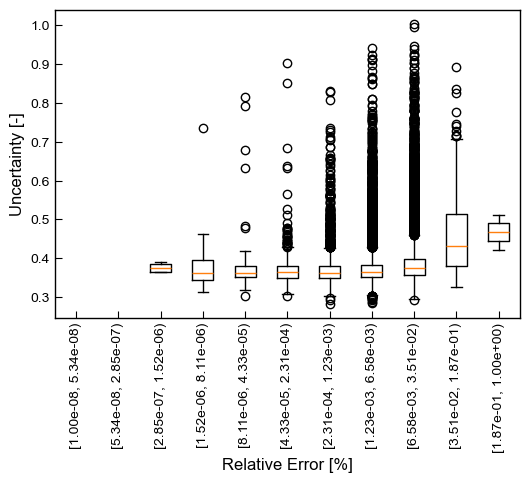

In [70]:
fig, ax = plt.subplots(figsize=(6,4))

label_names = [
    f"[{rel_error_bins[i]:.2e}, {rel_error_bins[i+1]:.2e})" 
    for i in range(len(rel_error_bins)-1)
]
plt.boxplot(uncertainty_bins_values,labels=label_names)

plt.xticks(rotation=90)

plt.ylabel('Uncertainty [-]')
plt.xlabel('Relative Error [%]')

plt.show()

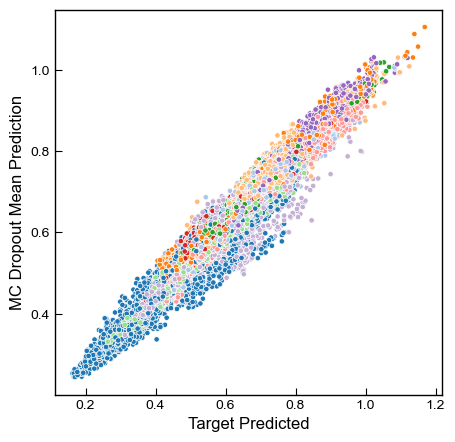

In [71]:
y_preds, _ = model.evaluate()

fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(y_preds, preds_mc_dropout_mean, 
            s=15, 
            facecolor=np.array(plot_params.morecolors)[clusters], 
            edgecolors='white',
            linewidth=0.5,
            zorder=1)
plt.xlabel("Target Predicted")
plt.ylabel("MC Dropout Mean Prediction")

plt.show()

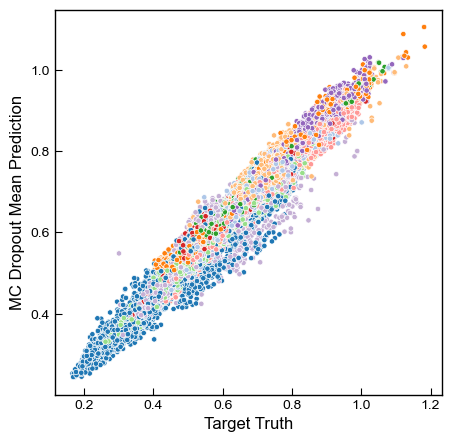

In [72]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(y_truth, preds_mc_dropout_mean, 
            s=15, 
            facecolor=np.array(plot_params.morecolors)[clusters], 
            edgecolors='white',
            linewidth=0.5,
            zorder=1)
plt.xlabel("Target Truth")
plt.ylabel("MC Dropout Mean Prediction")

plt.show()

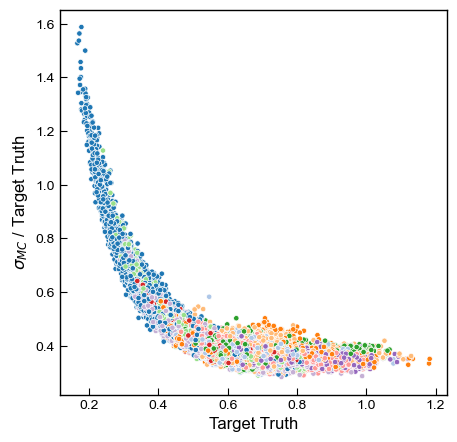

In [73]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(y_truth, preds_mc_dropout_std/y_truth, 
            s=15, 
            facecolor=np.array(plot_params.morecolors)[clusters], 
            edgecolors='white',
            linewidth=0.5,
            zorder=1)
plt.xlabel("Target Truth")
plt.ylabel("$\sigma_{MC}$ / Target Truth")

plt.show()

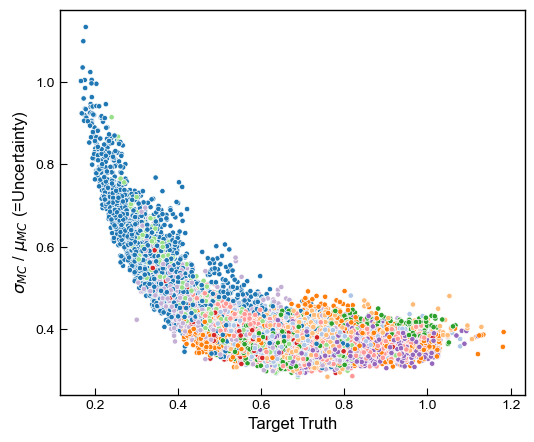

In [75]:
fig, ax = plt.subplots(figsize=(6,5))
plt.scatter(y_truth, uncertainty, 
            s=15, 
            facecolor=np.array(plot_params.morecolors)[clusters], 
            edgecolors='white',
            linewidth=0.5,
            zorder=1)
plt.xlabel("Target Truth")
plt.ylabel("$\sigma_{MC}$ / $\mu_{MC}$ (=Uncertainty)")

plt.show()

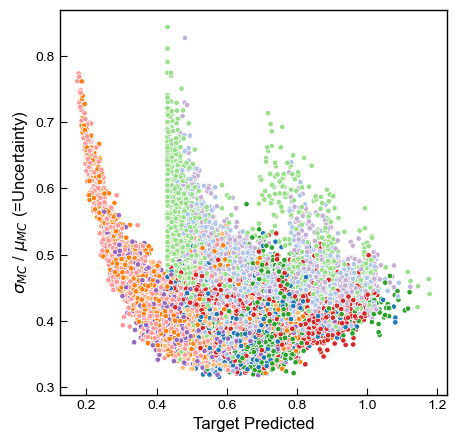

In [35]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(y_pred, uncertainty, 
            s=15, 
            facecolor=np.array(plot_params.morecolors)[clusters], 
            edgecolors='white',
            linewidth=0.5,
            zorder=1)
plt.xlabel("Target Predicted")
plt.ylabel("$\sigma_{MC}$ / $\mu_{MC}$ (=Uncertainty)")

plt.show()

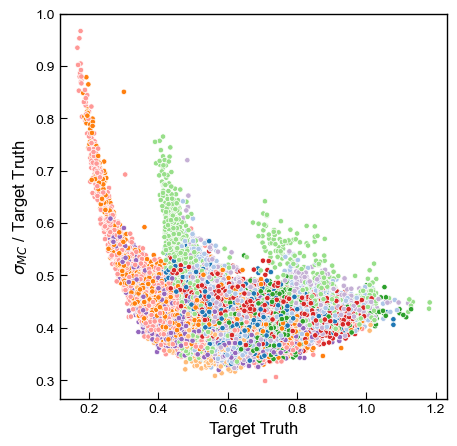

In [36]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(y_truth, preds_mc_dropout_std / y_truth, 
            s=15, 
            facecolor=np.array(plot_params.morecolors)[clusters], 
            edgecolors='white',
            linewidth=0.5,
            zorder=1)
plt.xlabel("Target Truth")
plt.ylabel("$\sigma_{MC}$ / Target Truth")

plt.show()

In [76]:
def compute_clt_confidence_interval(y_pred_samples, confidence=0.95):
    mean_pred = np.mean(y_pred_samples, axis=0)  
    std_pred = np.std(y_pred_samples, axis=0, ddof=1)  
    N = y_pred_samples.shape[0]  
    
    # Prevent division errors
    epsilon = 1e-6
    mean_pred = np.clip(mean_pred, epsilon, None)
    
    # Coefficient of Variation (CV)
    cv = std_pred / mean_pred  

    # Z-score for the given confidence level
    z_score = stats.norm.ppf(1 - (1 - confidence) / 2)

    # Confidence Interval (CLT-based)
    margin_of_error = z_score * (std_pred / np.sqrt(N))

    return mean_pred[0], margin_of_error[0], cv[0]  # Return full arrays (not scalars)

# Call function
mean_pred, margin_of_error, cv = compute_clt_confidence_interval(relative_deviation)

In [77]:
print(f"Confidence Interval: {mean_pred:.4f} ± {margin_of_error*100:.2f}% (95% CL)")

Confidence Interval: 0.1094 ± 0.65% (95% CL)


In [78]:
print(f"Confidence Interval: {np.mean(y_preds.numpy()/model.y_test.numpy()):.4f} ± {margin_of_error*100:.2f}% (95% CL)")

Confidence Interval: 1.0011 ± 0.65% (95% CL)


### Analysis of Uncertainty

Try to identify correlations between features and other metrics to the predicted uncertainty. 

#### Visual Inspection

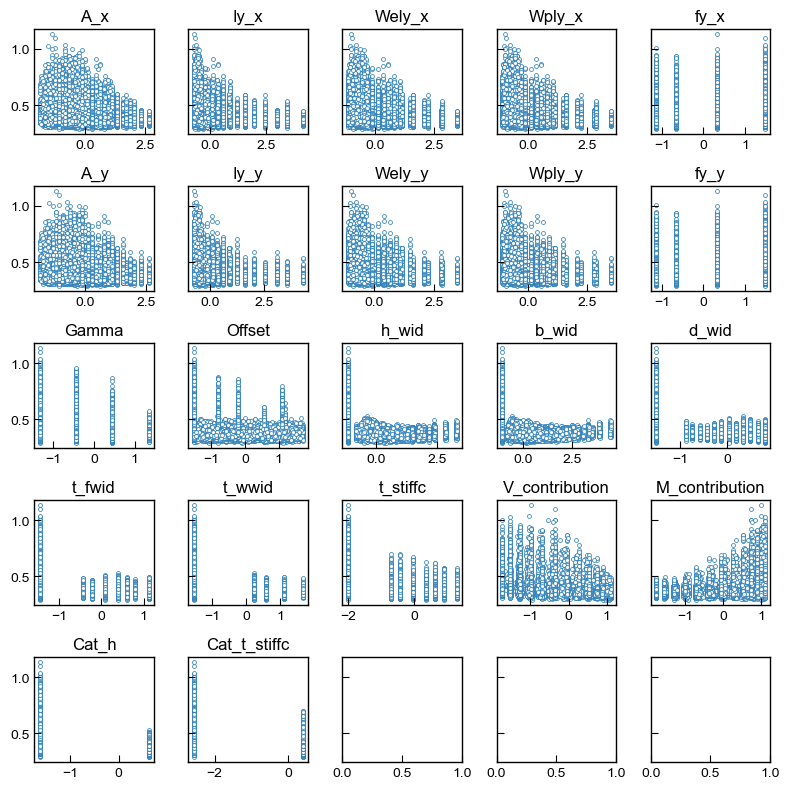

In [85]:
fig, axs = plt.subplots(int(len(model.features)/5)+1,5, figsize=(8,8), sharey=True)

for i, feature in enumerate(model.features):
    ax = axs[int(i/5), i%5]
    ax.scatter(model.x_test[:,i], uncertainty, 
               s=8, 
               edgecolor=plot_params.morecolors[0],
               linewidth=0.5,
               facecolor='white')
    ax.set_title(feature)

plt.tight_layout()
plt.show()

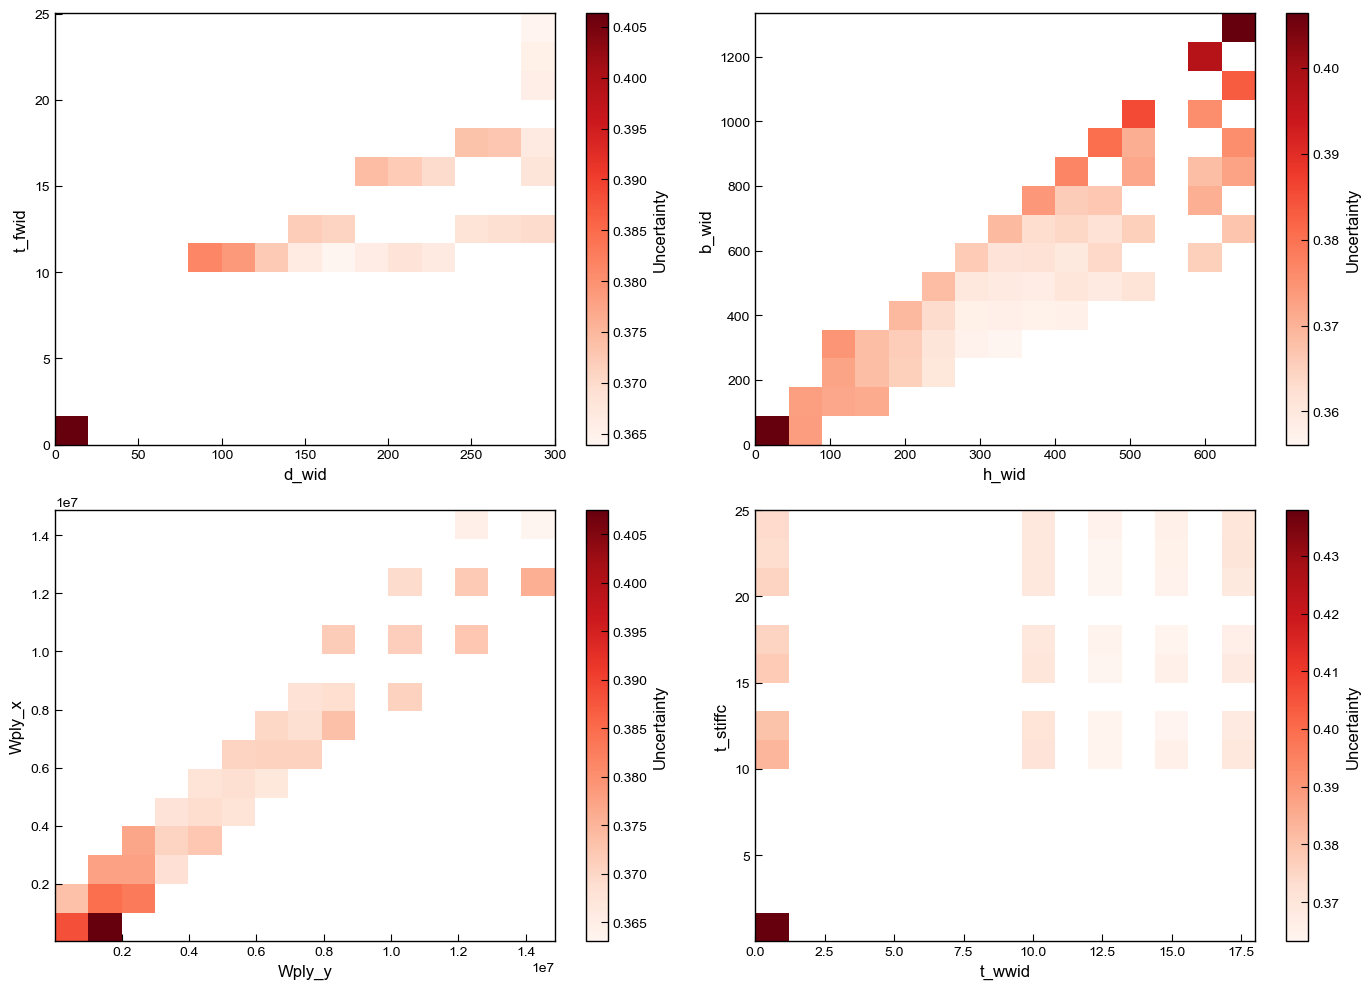

In [ ]:
x_test = model.x_test.numpy()
x_test = model.scaler_x.inverse_transform(x_test)
features = model.features

grid_x, grid_y = 15, 15

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i,(x_feature,y_feature) in enumerate(zip(['d_wid','h_wid','Wply_y','t_wwid'],['t_fwid','b_wid','Wply_x','t_stiffc'])):
    
    x_index = features.index(x_feature)
    y_index = features.index(y_feature)

    x = x_test[:, x_index]
    y = x_test[:, y_index]
    c = uncertainty.flatten()

    stat, x_edges, y_edges, _ = binned_statistic_2d(
        x, y, c, statistic='mean', bins=[grid_x, grid_y]
    )

    X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, 
                    (y_edges[:-1] + y_edges[1:]) / 2)

    pcm = axs[int(i/2),i%2].pcolormesh(X, Y, stat.T, cmap='Reds', shading='auto')

    fig.colorbar(pcm, ax=axs[int(i/2),i%2], label="Uncertainty")

    axs[int(i/2),i%2].set_xlabel(x_feature)
    axs[int(i/2),i%2].set_ylabel(y_feature)


plt.tight_layout()
plt.show()

#### Correlation Metrics

Calculate correlation metrics between **model features** and **uncertainty**.

In [150]:
def get_correlation_values(X, features, uncertainty):
    results = []
    
    for i, feature in enumerate(features):
        feature_values = X[:, i]

        pearson_corr, p_value = stats.pearsonr(feature_values, uncertainty)
        
        # 1. Spearman Rank Correlation
        spearman_corr, spearman_pval = stats.spearmanr(feature_values, uncertainty, nan_policy='omit')
        
        # 2. Mutual Information
        try:
            # Reshape for sklearn's API
            mi = mutual_info_regression(feature_values.reshape(-1, 1), uncertainty)[0]
        except:
            mi = np.nan
        
        # 3. Kendall's Tau (another rank correlation)
        kendall_tau, kendall_pval = stats.kendalltau(feature_values, uncertainty, nan_policy='omit')
        
        results.append({
            'Feature': feature,
            'Pearson Correlation': pearson_corr,
            'Pearson p-value': p_value,
            'Spearman Correlation': spearman_corr,
            'Spearman p-value': spearman_pval,
            'Kendall Tau': kendall_tau,
            'Kendall p-value': kendall_pval,
            'Mutual Information': mi
        })
    
    # Convert to DataFrame and sort by most significant metrics
    result_df = pd.DataFrame(results)
    return result_df

# Use the function
df_corr_metrics = get_correlation_values(model.x_test.numpy(), 
                                         model.features, 
                                         uncertainty.flatten())

df_corr_metrics

Feature  Pearson Correlation  Pearson p-value  \
0              A_x             0.217225     0.000000e+00   
1             Iy_x             0.241134     0.000000e+00   
2           Wely_x             0.239666     0.000000e+00   
3           Wply_x             0.239601     0.000000e+00   
4             fy_x            -0.028368     3.363925e-14   
5              A_y             0.229170     0.000000e+00   
6             Iy_y             0.228668     0.000000e+00   
7           Wely_y             0.234221     0.000000e+00   
8           Wply_y             0.234361     0.000000e+00   
9             fy_y            -0.028368     3.363925e-14   
10           Gamma            -0.113662    5.120398e-204   
11          Offset            -0.045961     1.015636e-34   
12           h_wid             0.325656     0.000000e+00   
13           b_wid             0.393202     0.000000e+00   
14           d_wid             0.122587    3.185346e-237   
15          t_fwid             0.199551     0.000000e+00   
16          t_wwid             0.157603     0.000000e+00   
17        t_stiffc            -0.054184     1.345868e-47   
18  V_contribution            -0.154509     0.000000e+00   
19  M_contribution             0.082943    2.941979e-109   

    Spearman Correlation  Spearman p-value  Kendall Tau  Kendall p-value  \
0               0.202680      0.000000e+00     0.140687     0.000000e+00   
1               0.215112      0.000000e+00     0.148881     0.000000e+00   
2               0.211071      0.000000e+00     0.146380     0.000000e+00   
3               0.211005      0.000000e+00     0.146163     0.000000e+00   
4              -0.041214      3.053272e-28    -0.030722     3.182009e-28   
5               0.216636      0.000000e+00     0.150185     0.000000e+00   
6               0.215705      0.000000e+00     0.149017     0.000000e+00   
7               0.213773      0.000000e+00     0.147901     0.000000e+00   
8               0.217232      0.000000e+00     0.150282     0.000000e+00   
9              -0.041214      3.053272e-28    -0.030722     3.182009e-28   
10             -0.100132     1.431665e-158    -0.074794    1.877423e-158   
11             -0.021435      1.005913e-08    -0.014552     7.413071e-09   
12              0.280155      0.000000e+00     0.200541     0.000000e+00   
13              0.290101      0.000000e+00     0.208180     0.000000e+00   
14              0.202569      0.000000e+00     0.154952     0.000000e+00   
15              0.297902      0.000000e+00     0.222276     0.000000e+00   
16              0.259149      0.000000e+00     0.197733     0.000000e+00   
17             -0.014959      6.380561e-05    -0.010595     6.212204e-05   
18             -0.198411      0.000000e+00    -0.133268     0.000000e+00   
19              0.198395      0.000000e+00     0.133289     0.000000e+00   

    Mutual Information  
0             0.074811  
1             0.073322  
2             0.072107  
3             0.072667  
4             0.005779  
5             0.086351  
6             0.083961  
7             0.085294  
8             0.087503  
9             0.005779  
10            0.012259  
11            0.010106  
12            0.150965  
13            0.162687  
14            0.052034  
15            0.105676  
16            0.078638  
17            0.005821  
18            0.087643  
19            0.085472

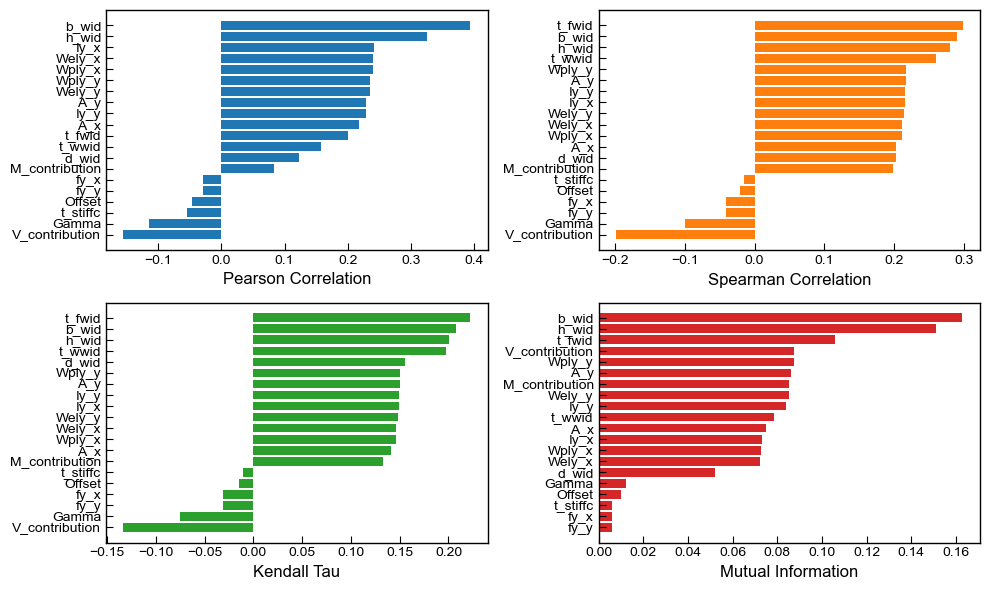

In [151]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Pearson Correlation
df_sorted_pearson = df_corr_metrics[['Feature', 'Pearson Correlation']].sort_values(by='Pearson Correlation', ascending=True)
axs[0,0].barh(df_sorted_pearson['Feature'], df_sorted_pearson['Pearson Correlation'], color=plot_params.colors[0])
axs[0,0].set_xlabel('Pearson Correlation')

# Spearman Correlation
df_sorted_spearman = df_corr_metrics[['Feature', 'Spearman Correlation']].sort_values(by='Spearman Correlation', ascending=True)
axs[0,1].barh(df_sorted_spearman['Feature'], df_sorted_spearman['Spearman Correlation'], color=plot_params.colors[1])
axs[0,1].set_xlabel('Spearman Correlation')

# Kendall Tau
df_sorted_kendall = df_corr_metrics[['Feature', 'Kendall Tau']].sort_values(by='Kendall Tau', ascending=True)
axs[1,0].barh(df_sorted_kendall['Feature'], df_sorted_kendall['Kendall Tau'], color=plot_params.colors[2])
axs[1,0].set_xlabel('Kendall Tau')

# Mutual Information
df_sorted_mutual_info = df_corr_metrics[['Feature', 'Mutual Information']].sort_values(by='Mutual Information', ascending=True)
axs[1,1].barh(df_sorted_mutual_info['Feature'], df_sorted_mutual_info['Mutual Information'], color=plot_params.colors[3])
axs[1,1].set_xlabel('Mutual Information')

# Adjust layout
plt.tight_layout()
plt.show()

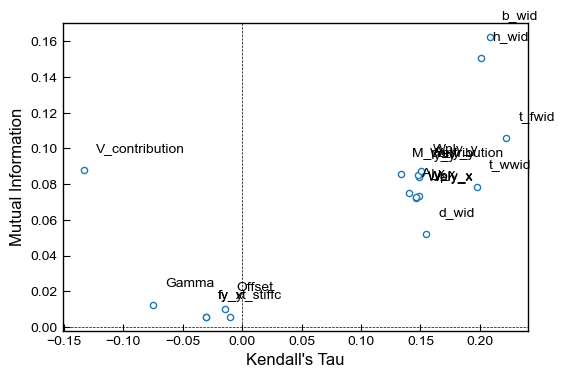

In [152]:
fig, ax = plt.subplots(figsize=(6,4))

plt.scatter(df_corr_metrics['Kendall Tau'], df_corr_metrics['Mutual Information'],
            s=20,
            edgecolor=plot_params.morecolors[0],
            linewidth=1.0,
            facecolor='white')

for i,row in df_corr_metrics.iterrows():
    plt.text(row['Kendall Tau']+0.01, row['Mutual Information']+0.01, row['Feature'], fontsize=10)

ax.axvline(0, color='k', linestyle='--', linewidth=0.5)
ax.axhline(0, color='k', linestyle='--', linewidth=0.5)

plt.xlabel("Kendall's Tau")
plt.ylabel("Mutual Information")

plt.show()

#### Feature Importance


Random Forest Feature Importances:
           Feature  Importance
18  V_contribution    0.212360
10           Gamma    0.138204
19  M_contribution    0.137344
13           b_wid    0.131643
0              A_x    0.044889
12           h_wid    0.032814
17        t_stiffc    0.031029
16          t_wwid    0.029133
14           d_wid    0.029079
3           Wply_x    0.027717
15          t_fwid    0.027165
6             Iy_y    0.025801
11          Offset    0.025562
1             Iy_x    0.021946
5              A_y    0.021542
7           Wely_y    0.019376
8           Wply_y    0.017927
2           Wely_x    0.014430
4             fy_x    0.006058
9             fy_y    0.005983


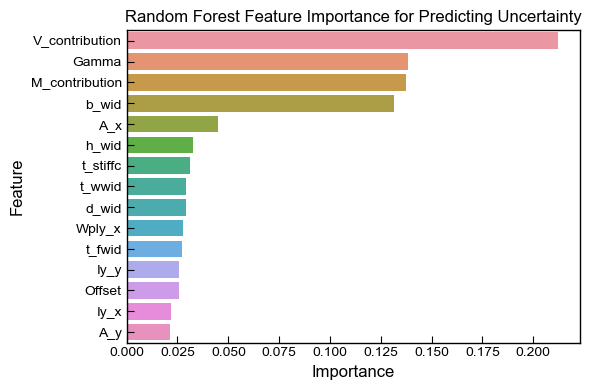

In [ ]:
# Ensure data is properly formatted
X = np.array(model.x_test, dtype=float)
y = np.array(uncertainty, dtype=float)

# Create and train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = pd.DataFrame({
    'Feature': model.features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nRandom Forest Feature Importances:")
print(importances)

# Plot feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=importances.head(15))
plt.title('Random Forest Feature Importance for Predicting Uncertainty')
plt.tight_layout()
plt.show()

### Training Loss

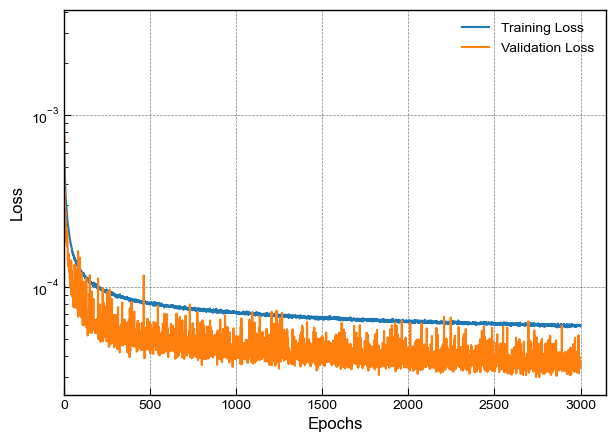

In [15]:
fig, ax = plt.subplots(figsize=(7,5))

plt.plot(model.train_losses['total'], label='Training Loss', c=plot_params.colors[0])
plt.plot(model.val_losses['total'], label='Validation Loss', c=plot_params.colors[1])

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.yscale('log')

plt.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)
plt.xlim([0,None])
plt.yscale('log')
plt.legend()

## MV Interaction Prediction

Visualize bad predictions and compare curves

In [18]:
def find_similar_profiles(x_profile,log=True):
    # Get the fixed features (all except M_contribution and V_contribution)
    fixed_features = [feat for feat in model.features if feat not in ['M_contribution', 'V_contribution']]
    
    # Create a hashable key from the fixed features of x_profile
    x_profile_key = tuple(x_profile[fixed_features].values.astype(np.float32))
    
    # Extract all profile data as a DataFrame for faster processing
    all_profiles_df = pd.DataFrame(model.x_data, columns=model.features)
    
    # Create mask for matching profiles
    mask = np.ones(len(all_profiles_df), dtype=bool)
    
    # Apply filter for each fixed feature
    for i, feature in enumerate(fixed_features):
        feature_idx = model.features.index(feature)
        mask &= (all_profiles_df.iloc[:, feature_idx] == x_profile_key[i])
    
    # Get indices of matching profiles
    profiles_similar = np.where(mask)[0].tolist()
    
    if log==True:
        print(f'{len(profiles_similar)} profiles found with the same fixed features')
    
    return profiles_similar

#### Plot Function

In [14]:
def plot_MV_interaction(x_profile,M_Rd_pred,V_Rd_pred):
    profiles_similar = find_similar_profiles(x_profile)

    M_Rd_truth = df["M_Rd"].to_numpy()[profiles_similar]
    V_Rd_truth = df["V_Rd"].to_numpy()[profiles_similar]
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.scatter(M_Rd_pred, V_Rd_pred, 
                s=50, 
                color=plot_params.morecolors[1], 
                edgecolors=plot_params.morecolors[0], 
                linewidth=1,                        
                label="Predicted")

    plt.scatter(M_Rd_truth, V_Rd_truth,
                s=50, 
                color=plot_params.morecolors[3], 
                edgecolors=plot_params.morecolors[2],  
                linewidth=1,
                label="Ground Truth")
    
    if "M_Rd" in x_profile.keys() and "V_Rd" in x_profile.keys():
        plt.scatter(x_profile["M_Rd"], x_profile["V_Rd"],
                    s=50, 
                    color=plot_params.morecolors[5], 
                    edgecolors=plot_params.morecolors[4],  
                    linewidth=1,
                    label="Input Profile")

    '''
    for i, txt in enumerate(predicitons_validity):
        ax.annotate(f"{txt:.2f}", (M_Rd_truth[i], V_Rd_truth[i]), fontsize=8)
    '''

    plt.xlabel("MRd [kNm]")
    plt.ylabel("VRd [kN]")
    plt.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)

    legend_labels = ['Predicted', 'Ground Truth']
    legend_handles = [
        plt.Line2D([], [], marker='o', color='w', markerfacecolor=plot_params.morecolors[1], markeredgecolor=plot_params.morecolors[0], markersize=7),
        plt.Line2D([], [], marker='o', color='w', markerfacecolor=plot_params.morecolors[3], markeredgecolor=plot_params.morecolors[2], markersize=7),
    ]

    if "M_Rd" in x_profile.keys() and "V_Rd" in x_profile.keys():
        legend_labels.append("Input Profile")
        legend_handles.append(plt.Line2D([], [], marker='o', color='w', markerfacecolor=plot_params.morecolors[5], markeredgecolor=plot_params.morecolors[4], markersize=7))

    plt.xlim([0,None])
    plt.ylim([0,None])

    plt.legend(legend_handles, legend_labels)

    plt.show()

#### Plot MV Interaction Curve

In [ ]:
x_profile = df.iloc[100]

M_Rd_pred, V_Rd_pred, targets_predicted = model.get_MV_interaction_prediction(x_profile,n_predictions=20)
profiles_similar = find_similar_profiles(x_profile)

M_Rd_truth = df["M_Rd"].to_numpy()[profiles_similar]
V_Rd_truth = df["V_Rd"].to_numpy()[profiles_similar]

7 profiles found with the same fixed features


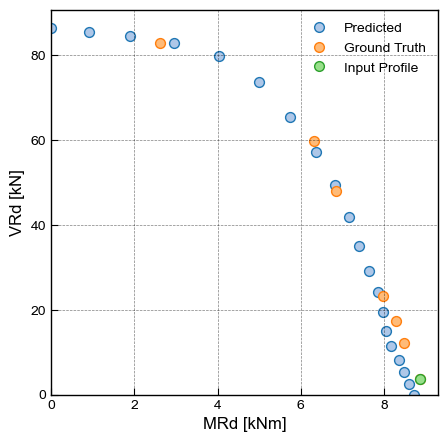

In [44]:
plot_MV_interaction(x_profile,M_Rd_pred,V_Rd_pred)

6 profiles found with the same fixed features


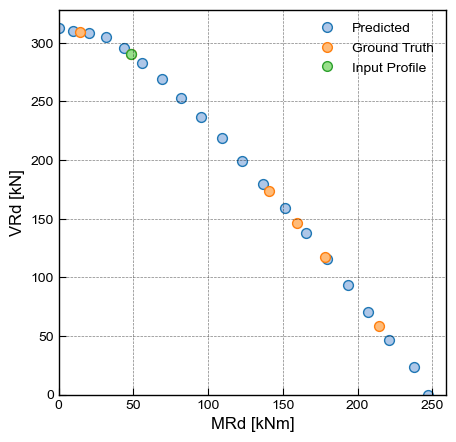

8 profiles found with the same fixed features


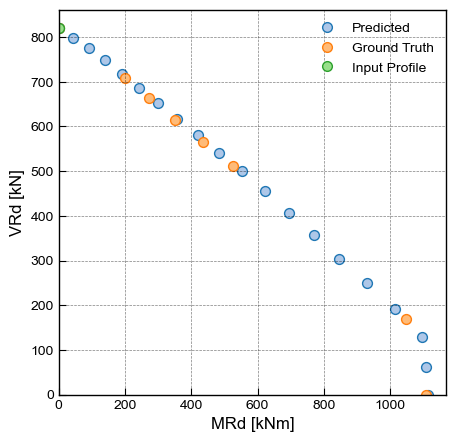

5 profiles found with the same fixed features


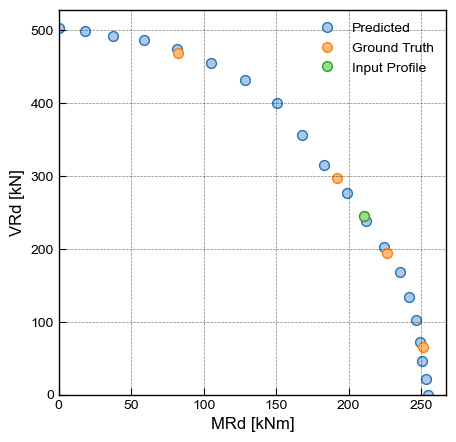

5 profiles found with the same fixed features


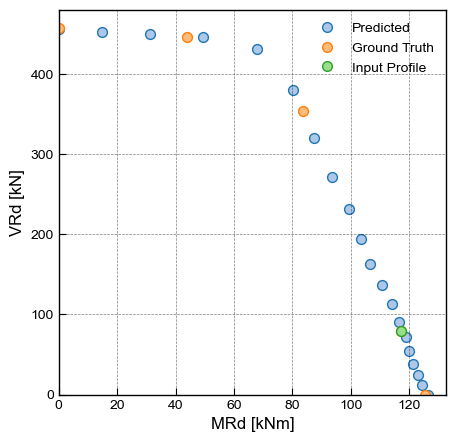

6 profiles found with the same fixed features


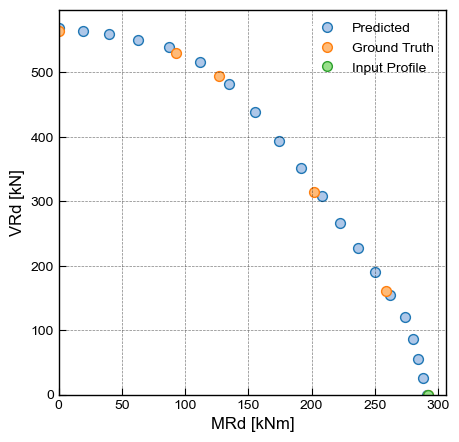

3 profiles found with the same fixed features


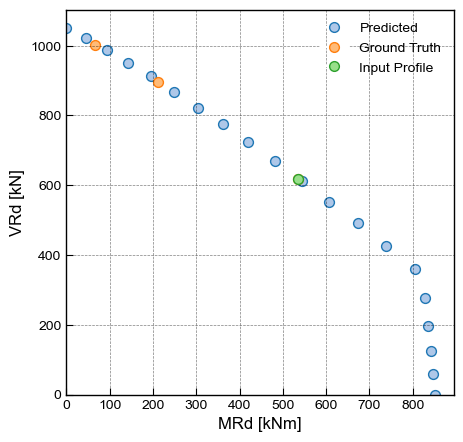

4 profiles found with the same fixed features


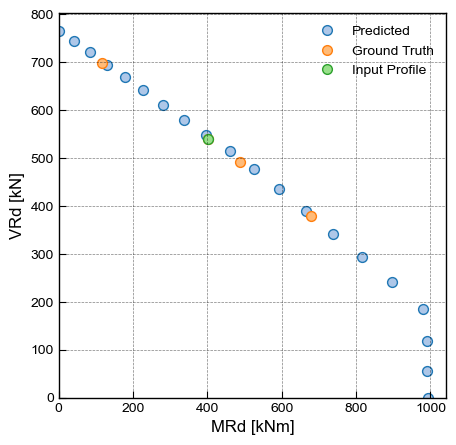

6 profiles found with the same fixed features


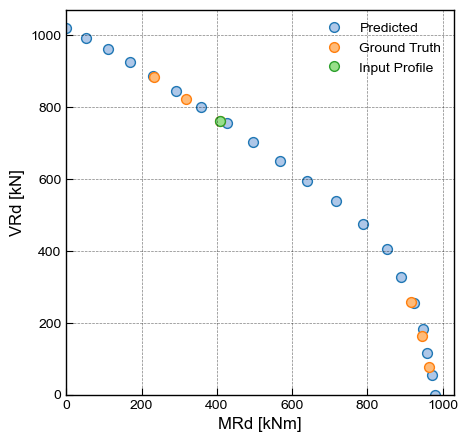

6 profiles found with the same fixed features


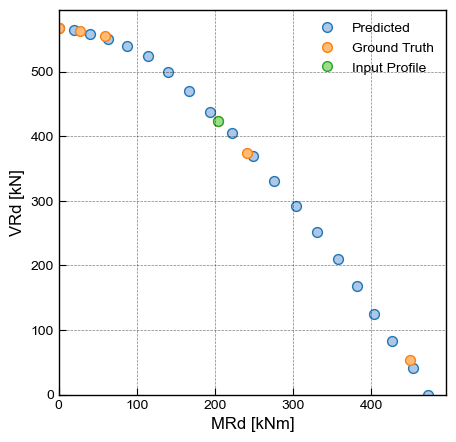

9 profiles found with the same fixed features


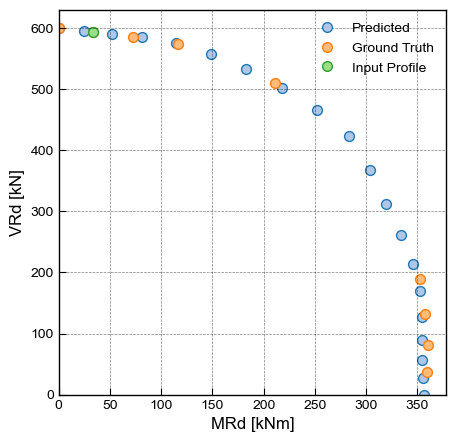

In [94]:
profiles_ids = np.random.randint(0, len(df), 10)
for profile_id in profiles_ids:
    x_profile = df.iloc[profile_id]
    M_Rd_pred, V_Rd_pred, targets_predicted = model.get_MV_interaction_prediction(x_profile,n_predictions=20)
    plot_MV_interaction(x_profile,M_Rd_pred,V_Rd_pred)

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
8 profiles found with the same fixed features


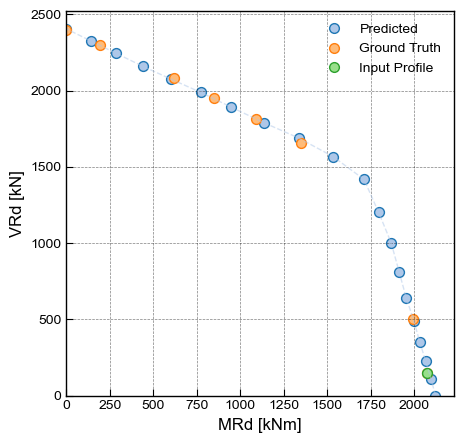

In [47]:
from Plot_Functions import plot_MV_interaction

x_profile = df_test.sample(1) # iloc because argsort returns also index
plot_MV_interaction(x_profile,model,df_full,n=20)

## Measure M and V deviation

In [95]:
df_test = df_full.loc[model.data['test_data']].copy()

In [ ]:
target_preds, _ = model.evaluate()
target_preds = target_preds.numpy().flatten()
target_truth = model.y_test.numpy().flatten()

In [98]:
Mpl_y = df_test['Mpl_y'].values
Vpl_y = df_test['Vpl_y'].values

M_cont = df_test['M_contribution'].values
V_cont = df_test['V_contribution'].values

M_Rd_pred = target_preds * Mpl_y * M_cont
V_Rd_pred = target_preds * Vpl_y * V_cont

M_Rd_truth = target_truth * Mpl_y * M_cont
V_Rd_truth = target_truth * Vpl_y * V_cont

M_Rd_error = M_Rd_pred - M_Rd_truth
M_Rd_rel_error = (M_Rd_pred - M_Rd_truth) / (M_Rd_truth+1e-4) * 100

V_Rd_error = V_Rd_pred - V_Rd_truth
V_Rd_rel_error = (V_Rd_pred - V_Rd_truth) / (V_Rd_truth+1e-4) * 100

target_error = target_preds - target_truth
target_rel_error = target_preds / target_truth

In [99]:
error_distance = np.sqrt(M_Rd_error**2 + V_Rd_error**2)
length_predicted = np.sqrt(M_Rd_pred**2 + V_Rd_pred**2)
length_truth = np.sqrt(M_Rd_truth**2 + V_Rd_truth**2)
angle_predicted = np.arctan2(V_Rd_pred, M_Rd_pred)
angle_truth = np.arctan2(V_Rd_truth, M_Rd_truth)

In [100]:
def get_outlier(data,z_score=1.5):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1

    lower_bound = q1 - z_score * iqr
    upper_bound = q3 + z_score * iqr

    mask = (data >= lower_bound) & (data <= upper_bound)
    return mask

z_score = 15
filter_outlier_MRd = get_outlier(M_Rd_rel_error, z_score=z_score)
filter_outlier_VRd = get_outlier(V_Rd_rel_error, z_score=z_score)

filter_outlier = filter_outlier_MRd & filter_outlier_VRd

print(f"# Outliers with z_score = {z_score}: ", len(M_Rd_rel_error) - len(M_Rd_rel_error[filter_outlier]))

# Outliers with z_score = 15:  13


NameError: name 'results' is not defined

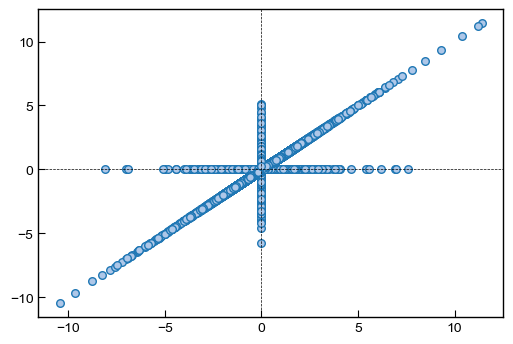

In [101]:
fig, ax = plt.subplots(figsize=(6,4))

plt.scatter(M_Rd_rel_error[filter_outlier],
            V_Rd_rel_error[filter_outlier],
            s=30,
            edgecolors=plot_params.morecolors[0],
            facecolor=plot_params.morecolors[1],
            linewidth=1.0,
            )

plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.axvline(0, color='k', linestyle='--', linewidth=0.5)

plt.axhline(np.mean(V_Rd_rel_error), color=plot_params.colors[3], linestyle='--', linewidth=0.5, label=f"Mean VRd Error: {np.mean(results['V_Rd_rel_error']):.2f}%")
plt.axvline(np.mean(M_Rd_rel_error), color=plot_params.colors[2], linestyle='--', linewidth=0.5, label=f"Mean MRd Error: {np.mean(results['M_Rd_rel_error']):.2f}%")

plt.xlabel("MRd Error [%]")
plt.ylabel("VRd Error [%]")

plt.legend()

plt.show()

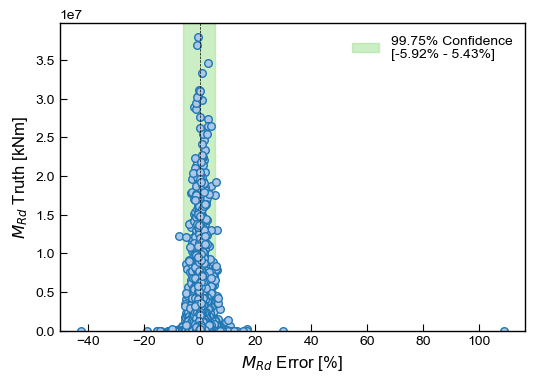

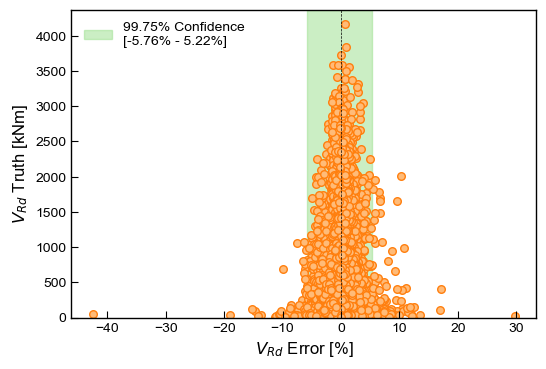

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

confidence = 99.75
q_lower, q_upper = np.percentile(M_Rd_rel_error, [(100-confidence)/2, confidence-(100-confidence)/2])

plt.scatter(M_Rd_rel_error,
            M_Rd_truth,
            s=30,
            edgecolors=plot_params.morecolors[0],
            facecolor=plot_params.morecolors[1],
            linewidth=1.0,
            )

ax.axvspan(q_lower, q_upper, alpha=0.5, color=plot_params.morecolors[5], 
           label=f"{confidence}% Confidence\n[{q_lower:.2f}% - {q_upper:.2f}%]", zorder=0)

plt.axvline(0, color='k', linestyle='--', linewidth=0.5)

plt.xlabel("$M_{Rd}$ Error [%]")
plt.ylabel("$M_{Rd}$ Truth [kNm]")

plt.ylim([0,None])
plt.legend()

plt.show()

fig, ax = plt.subplots(figsize=(6,4))

confidence = 99.75
q_lower, q_upper = np.percentile(V_Rd_rel_error, [(100-confidence)/2, confidence-(100-confidence)/2])

plt.scatter(V_Rd_rel_error,
            V_Rd_truth,
            s=30,
            edgecolors=plot_params.morecolors[2],
            facecolor=plot_params.morecolors[3],
            linewidth=1.0,
            )

ax.axvspan(q_lower, q_upper, alpha=0.5, color=plot_params.morecolors[5], 
           label=f"{confidence}% Confidence\n[{q_lower:.2f}% - {q_upper:.2f}%]", zorder=0)

plt.axvline(0, color='k', linestyle='--', linewidth=0.5)

plt.xlabel("$V_{Rd}$ Error [%]")
plt.ylabel("$V_{Rd}$ Truth [kNm]")

plt.ylim([0,None])
plt.legend()

plt.show()


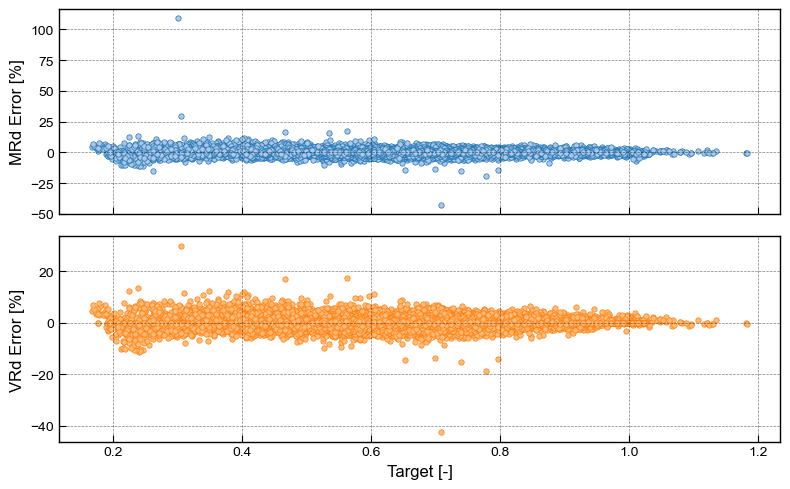

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(8,5), sharex=True)

axs[0].scatter(y_truth, M_Rd_rel_error,
               s=15, 
            facecolor=plot_params.morecolors[1], 
            edgecolors=plot_params.morecolors[0],
            linewidth=0.5,
            zorder=1)

axs[1].scatter(y_truth, V_Rd_rel_error,
               s=15, 
            facecolor=plot_params.morecolors[3], 
            edgecolors=plot_params.morecolors[2],
            linewidth=0.5,
            zorder=1)

axs[0].set_ylabel("MRd Error [%]")
axs[1].set_ylabel("VRd Error [%]")
axs[1].set_xlabel("Target [-]")

axs[0].grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)
axs[1].grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)

plt.tight_layout()
plt.show()

With filtered outliers:

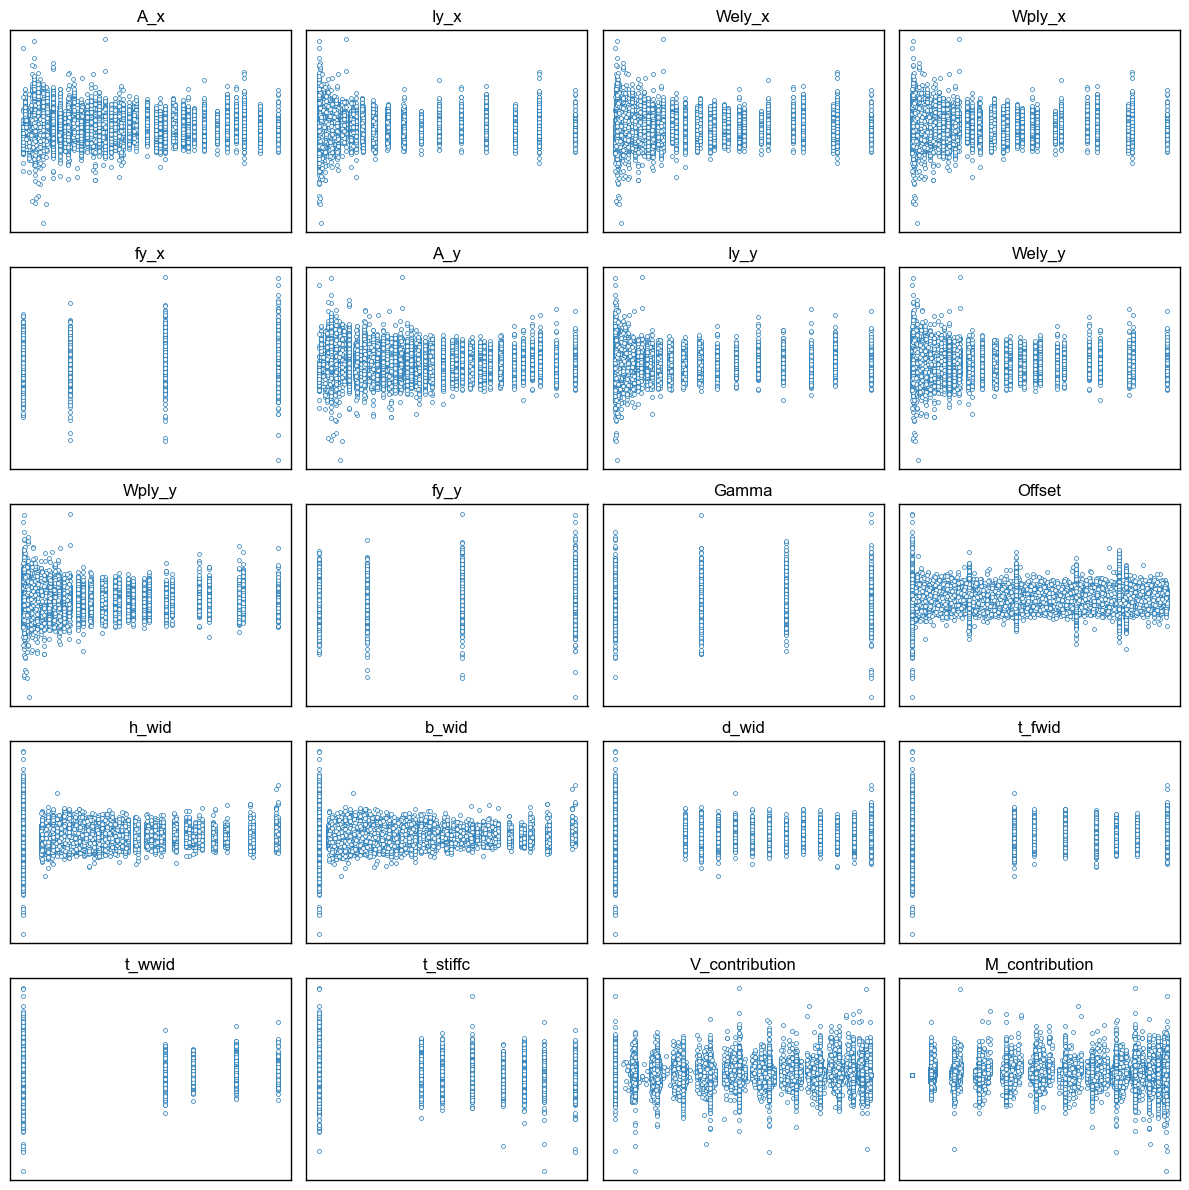

In [ ]:
fig, axs = plt.subplots(int(len(model.features)/4),4, figsize=(12,12), sharey=True)

for i, feature in enumerate(model.features):
    ax = axs[int(i/4), i%4]
    ax.scatter(df_test[feature][filter_outlier], M_Rd_rel_error[filter_outlier], 
               s=8, 
               edgecolor=plot_params.morecolors[0],
               linewidth=0.5,
               facecolor='white')
    ax.set_title(feature)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

#### Find Correlation from bad predictions with features

In [78]:
worst_predictions = np.argsort(relative_deviation.flatten())[-1000:]

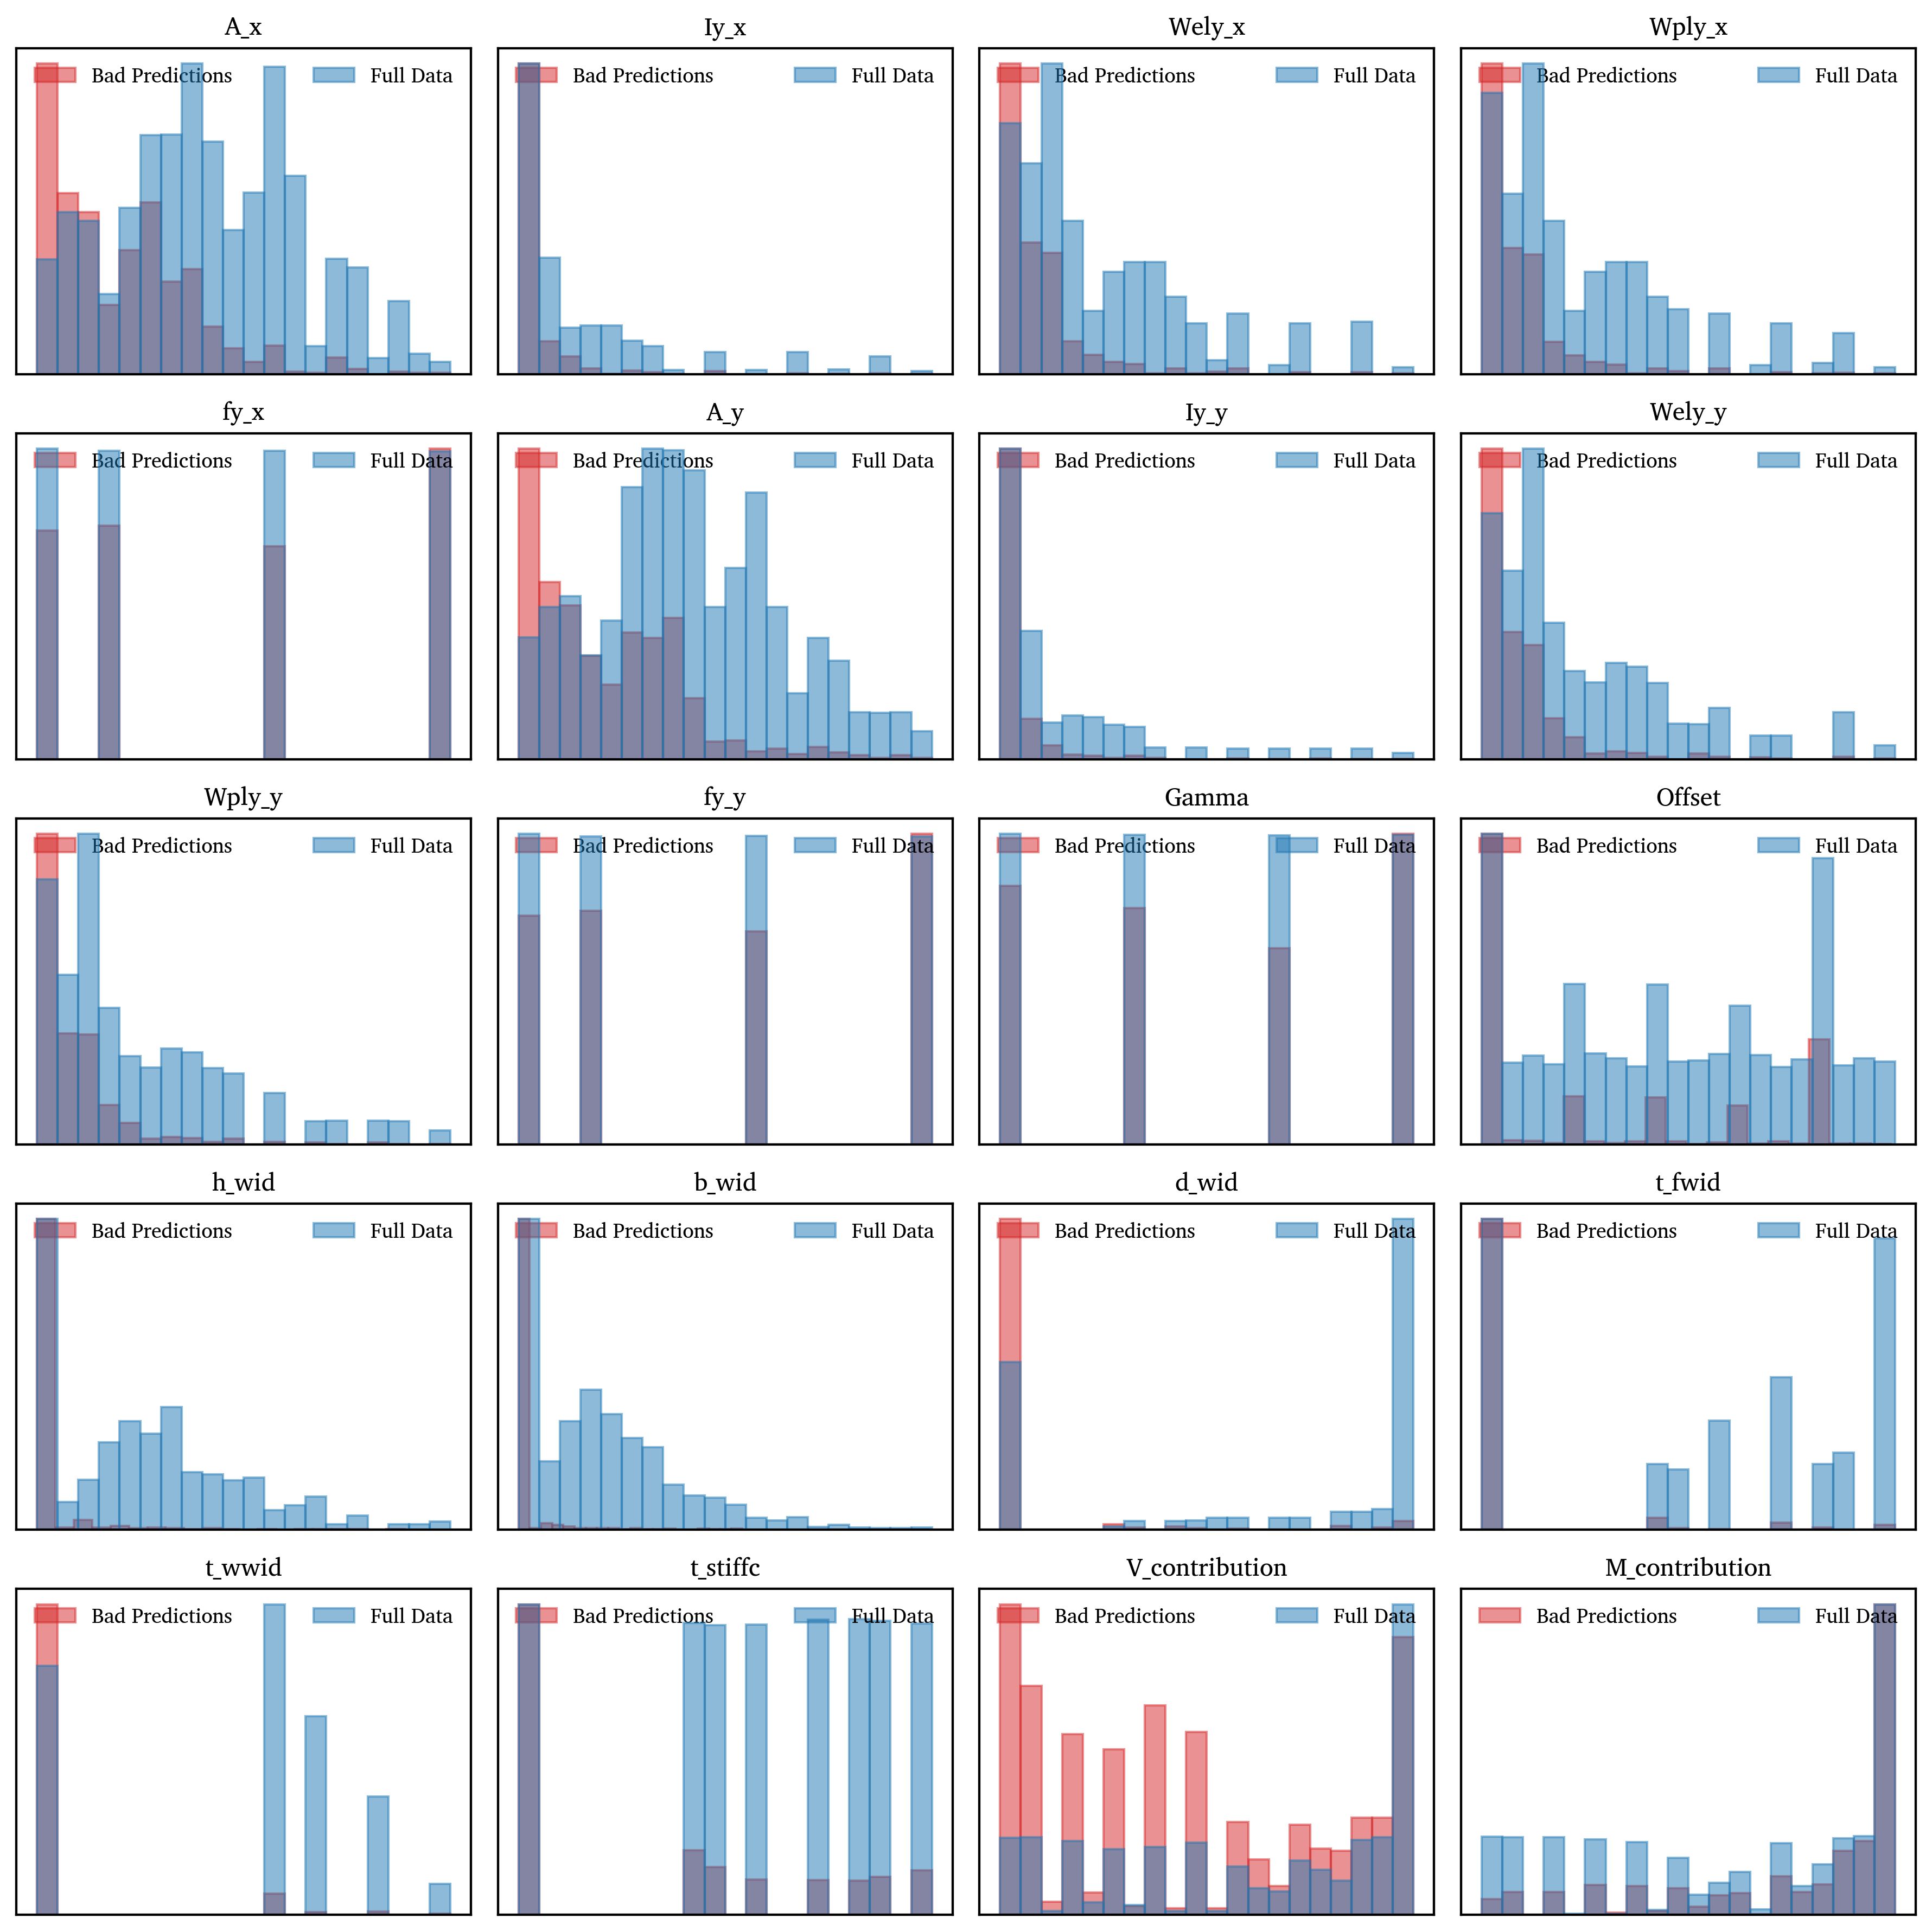

In [ ]:
fig, axs = plt.subplots(int(len(model.features)/4), 4, figsize=(12, 12), sharey=False)

for i, feature in enumerate(model.features):
    ax = axs[int(i/4), i%4]
    ax2 = ax.twinx()

    normed_bad_data = (df_test[feature].iloc[worst_predictions].values - df_test[feature].min()) / (df_test[feature].max() - df_test[feature].min())
    normed_full_data = (df_full[feature].values - df_full[feature].min()) / (df_full[feature].max() - df_full[feature].min())

    ax.hist(normed_bad_data, bins=20, 
            edgecolor=plot_params.colors[3], 
            facecolor=plot_params.colors[3],
            alpha=0.5, label='Bad Predictions')
    ax2.hist(normed_full_data, bins=20, 
             edgecolor=plot_params.colors[0],
             facecolor=plot_params.colors[0],
             alpha=0.5, label='Full Data')

    ax.set_title(feature)
    ax.set_xticks([])
    ax.set_yticks([])
    ax2.set_yticks([])
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


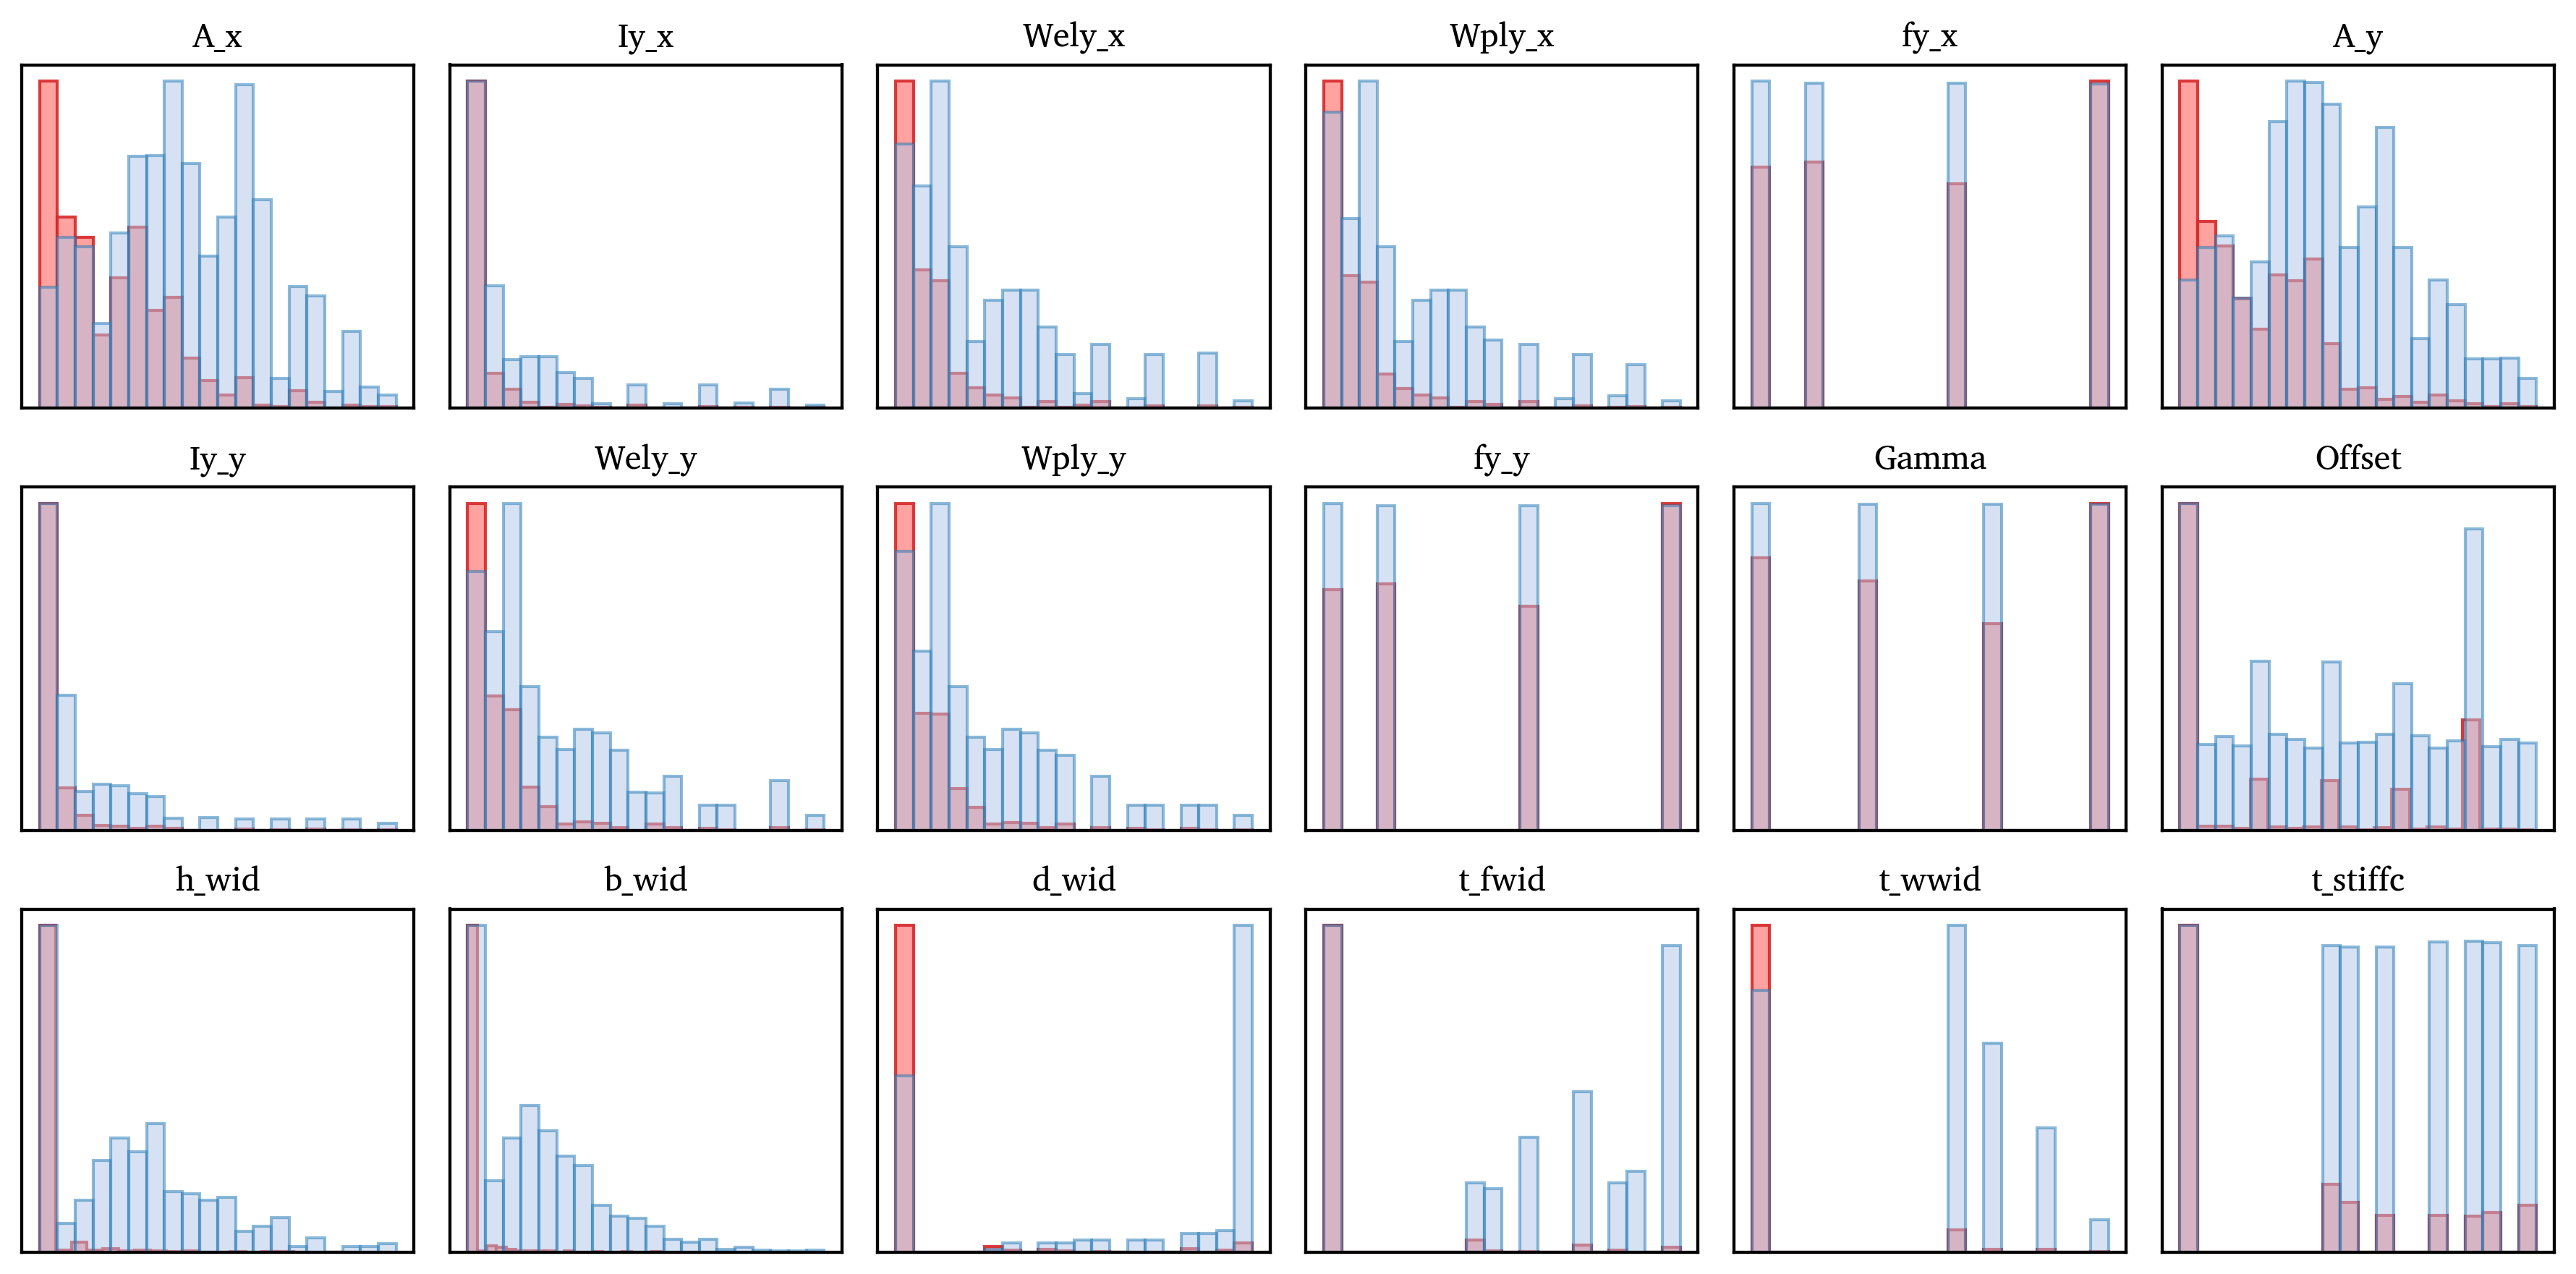

In [ ]:
fig, axs = plt.subplots(int(len(model.features)/6), 6, figsize=(12, 6), sharey=False)

for i, feature in enumerate(model.features[:-2]):
    ax = axs[int(i/6), i%6]
    ax2 = ax.twinx()

    normed_bad_data = (df_test[feature].iloc[worst_predictions].values - df_test[feature].min()) / (df_test[feature].max() - df_test[feature].min())
    normed_full_data = (df_full[feature].values - df_full[feature].min()) / (df_full[feature].max() - df_full[feature].min())

    ax2.hist(normed_full_data, bins=20, 
             edgecolor=plot_params.morecolors[0],
             facecolor=plot_params.morecolors[1],
             alpha=0.5, label='Full Data')
    ax.hist(normed_bad_data, bins=20, 
            edgecolor=plot_params.morecolors[6], 
            facecolor=plot_params.morecolors[7],
            alpha=0.9, label='Worst Predictions')

    ax.set_title(feature)
    ax.set_xticks([])
    ax.set_yticks([])
    ax2.set_yticks([])

plt.tight_layout()
plt.show()

### Multi-Dimensional Correlation

Try to predict the model error from the features with an XGBoost Random Forest and a Deep Neural Network. Both approaches do not show potential.

In [294]:
from xgboost import XGBRegressor
# Hyperparameter tuning with RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
df_tree = df_test.copy()
scaler = StandardScaler()

df_tree['target_rel_error'] = target_rel_error
df_tree['target_rel_error_norm'] = scaler.fit_transform(target_rel_error.reshape(-1, 1))

NameError: name 'df_test' is not defined

In [292]:
n_tree = len(df_tree)
test_split = 0.2
n_test = int(n_tree * test_split)

test_ids = np.random.choice(n_tree, n_test, replace=False)
train_ids = np.setdiff1d(np.arange(n_tree), test_ids)

df_tree_train = df_tree.iloc[train_ids].copy()
df_tree_test = df_tree.iloc[test_ids].copy()

x_tree_train = df_tree_train[model.features].values
y_tree_train = df_tree_train['target_rel_error_norm'].values

x_tree_test = df_tree_test[model.features].values
y_tree_test = df_tree_test['target_rel_error_norm'].values

In [295]:
tree_model = XGBRegressor(
    n_estimators=1000,
    max_depth=9,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.6,
    reg_lambda=0.1,
    reg_alpha=0.1,
    random_state=42
)
tree_model.fit(x_tree_train, y_tree_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [298]:
predicted_rel_error_norm = tree_model.predict(x_tree_test)

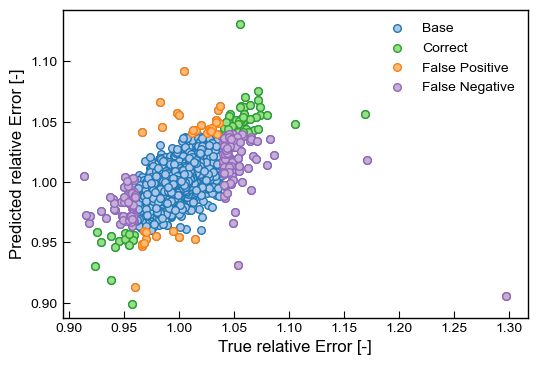

In [325]:
fig, ax = plt.subplots(figsize=(6,4))

rel_error_true = scaler.inverse_transform(y_tree_test.reshape(-1,1))
rel_error_pred = scaler.inverse_transform(predicted_rel_error_norm.reshape(-1,1))

mask_correct = (rel_error_true > 1.04) & (rel_error_pred > 1.04) | (rel_error_true < 0.96) & (rel_error_pred < 0.96)
mask_FN = (rel_error_true > 1.04) & (rel_error_pred <= 1.04) | (rel_error_true < 0.96) & (rel_error_pred >= 0.96)
mask_FP = (rel_error_true <= 1.04) & (rel_error_pred > 1.04) | (rel_error_true > 0.96) & (rel_error_pred <= 0.96)

plt.scatter(rel_error_true,
            rel_error_pred,
            s=30,
            edgecolors=plot_params.morecolors[0],
            facecolor=plot_params.morecolors[1],
            linewidth=1.0,
            label='Base'
            )

plt.scatter(rel_error_true[mask_correct],
            rel_error_pred[mask_correct],
            s=30,
            edgecolors=plot_params.morecolors[4],
            facecolor=plot_params.morecolors[5],
            linewidth=1.0,
            label='Correct'
            )

plt.scatter(rel_error_true[mask_FP],
            rel_error_pred[mask_FP],
            s=30,
            edgecolors=plot_params.morecolors[2],
            facecolor=plot_params.morecolors[3],
            linewidth=1.0,
            label='False Positive'
            )

plt.scatter(rel_error_true[mask_FN],
            rel_error_pred[mask_FN],
            s=30,
            edgecolors=plot_params.morecolors[8],
            facecolor=plot_params.morecolors[9],
            linewidth=1.0,
            label='False Negative'
            )

plt.xlabel("True relative Error [-]")
plt.ylabel("Predicted relative Error [-]")

plt.legend()

plt.show()

Feature Importance:

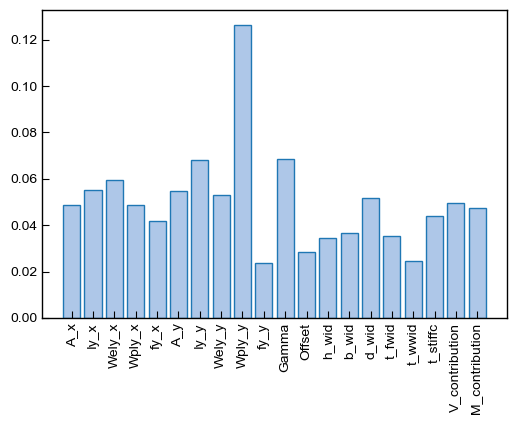

In [309]:
plt.bar(
    range(len(tree_model.feature_importances_)),
    tree_model.feature_importances_,
    color=plot_params.morecolors[1],
    edgecolor=plot_params.morecolors[0],
)

plt.xticks(range(len(tree_model.feature_importances_)), model.features, rotation=90)

plt.show()

#### Deep Neural Network to predict error

In [ ]:
df_error = df_test.copy()
scaler = StandardScaler()
df_error['target_rel_error_norm'] = scaler.fit_transform(target_rel_error.reshape(-1, 1))

In [342]:
model_error = DNN()

model_error.config['epochs'] = 100
model_error.config['dropout_prob'] = 0.00
model_error.config['neurons_per_layer'] = [64, 32, 16]
model_error.config['seed'] = 42
model_error.config['learning_rate'] = 0.05
model_error.config['test_size'] = 0.2

model_error.target = 'target_rel_error_norm'

model_error.prepare_data(df_error)
model_error.build()
model_error.train()

Number of training samples: 50007
Number of validation samples: 7144
Number of testing samples: 14288
Epoch 1/100, Train Loss: 1.013278, Val Loss: 0.987100
Epoch 2/100, Train Loss: 1.004508, Val Loss: 0.997150
Epoch 3/100, Train Loss: 1.013682, Val Loss: 0.992678
Epoch 4/100, Train Loss: 1.014072, Val Loss: 0.993815
Epoch 5/100, Train Loss: 1.018488, Val Loss: 0.994039
Epoch 6/100, Train Loss: 1.017578, Val Loss: 1.005997
Epoch 7/100, Train Loss: 1.015929, Val Loss: 0.994138
Epoch 8/100, Train Loss: 1.014506, Val Loss: 0.992500
Epoch 9/100, Train Loss: 1.014298, Val Loss: 0.997896
Epoch 10/100, Train Loss: 1.016656, Val Loss: 0.992583
Epoch 11/100, Train Loss: 1.015514, Val Loss: 0.994022
Epoch 12/100, Train Loss: 1.015829, Val Loss: 0.996088
Epoch 13/100, Train Loss: 1.015932, Val Loss: 0.993884
Epoch 14/100, Train Loss: 1.015643, Val Loss: 1.008517
Epoch 15/100, Train Loss: 1.018037, Val Loss: 0.997680
Epoch 16/100, Train Loss: 1.014255, Val Loss: 0.993434
Epoch 17/100, Train Loss: 1

In [ ]:
error_preds, _ = model_error.evaluate()
metrics = model_error.get_metrics()

In [345]:
metrics

{'MSE': 0.894448,
 'RMSE': 0.9457526,
 'MAE': 0.64987564,
 'R2': 0.001535177230834961,
 'MCDMS': 2534.1820922677152,
 'MCDUS': 0.0074380249019625365}

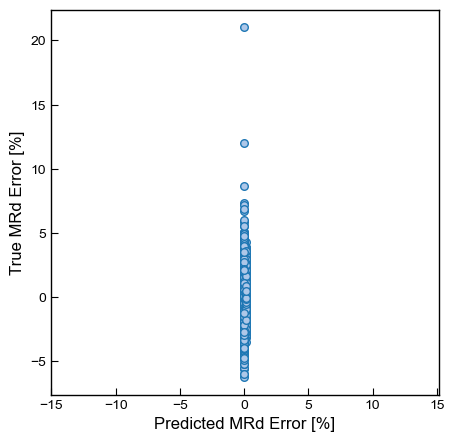

In [346]:
fig, ax = plt.subplots(figsize=(5,5))

plt.scatter(error_preds,
            model_error.y_test.numpy(),
            edgecolors=plot_params.morecolors[0],
            facecolor=plot_params.morecolors[1],
            s=30,)

plt.axis('equal')

plt.xlabel("Predicted MRd Error [%]")
plt.ylabel("True MRd Error [%]")

plt.show()